In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import numpy as np

### Tennessee Eastman Process dataset:

Возможные причинно-следственные связи между 33 датчиками (из 52)
(из статьи "CIPCaD-Bench: Continuous Industrial Process datasets for benchmarking Causal Discovery methods"):

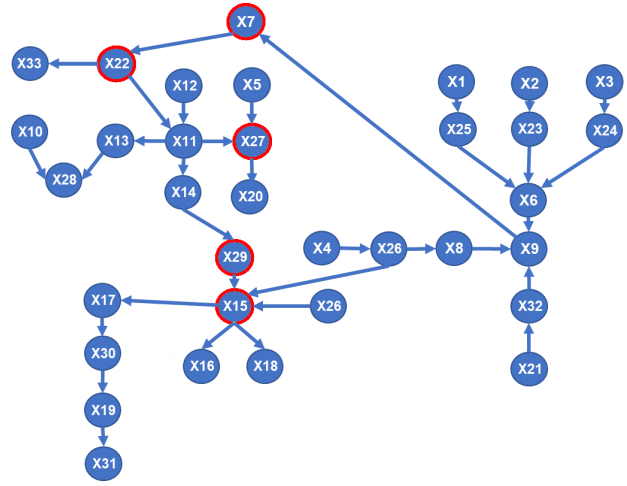

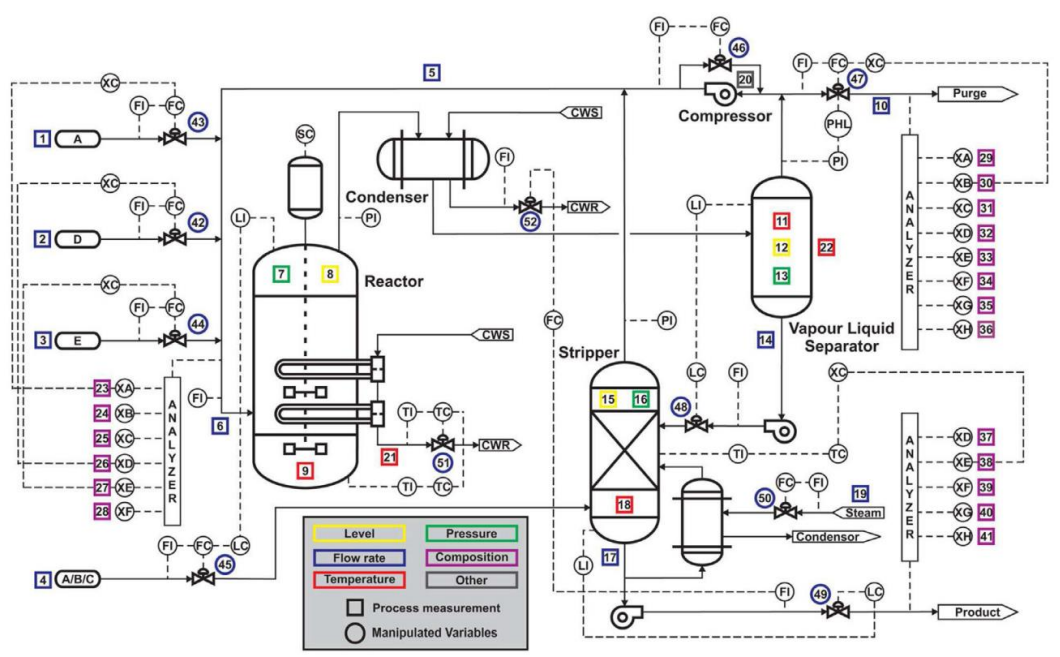

#### Установка Tennessee Eastman Process benchmark:

In [3]:
#!pip install git+https://github.com/airi-industrial-ai/fddbenchmark

In [4]:
from fddbenchmark import FDDDataset, FDDDataloader, FDDEvaluator

#### Загрузка датасета:

In [5]:
# 'small_tep'    - 20 faults, 18.9 MB
# 'rieth_tep'    - 20 faults, 1.84 GB
# 'reinartz_tep' - 28 faults, 1.88 GB

data = FDDDataset(name='small_tep')

Reading data/small_tep/test_mask.csv: 100%|██████████| 153300/153300 [00:00<00:00, 2612079.20it/s]


In [6]:
data.df

xmeas_1  xmeas_2  xmeas_3  xmeas_4  xmeas_5  xmeas_6  \
run_id    sample                                                         
413402073 1       0.25038   3674.0   4529.0   9.2320   26.889   42.402   
          2       0.25109   3659.4   4556.6   9.4264   26.721   42.576   
          3       0.25038   3660.3   4477.8   9.4426   26.875   42.070   
          4       0.24977   3661.3   4512.1   9.4776   26.758   42.063   
          5       0.29405   3679.0   4497.0   9.3381   26.889   42.650   
...                   ...      ...      ...      ...      ...      ...   
312148819 956     0.24842   3694.2   4491.2   9.3946   26.780   42.655   
          957     0.22612   3736.4   4523.1   9.3655   26.778   42.730   
          958     0.22386   3692.8   4476.5   9.3984   26.673   42.528   
          959     0.22561   3664.2   4483.0   9.4293   26.435   42.469   
          960     0.22585   3717.6   4492.8   9.4061   26.869   42.176   

                  xmeas_7  xmeas_8  xmeas_9  xmeas_10  ...   xmv_2   xmv_3  \
run_id    sample                                       ...                   
413402073 1        2704.3   74.863   120.41   0.33818  ...  53.744  24.657   
          2        2705.0   75.000   120.41   0.33620  ...  53.414  24.588   
          3        2706.2   74.771   120.42   0.33563  ...  54.357  24.666   
          4        2707.2   75.224   120.39   0.33553  ...  53.946  24.725   
          5        2705.1   75.388   120.39   0.32632  ...  53.658  28.797   
...                   ...      ...      ...       ...  ...     ...     ...   
312148819 956      2708.3   74.765   120.41   0.32959  ...  53.891  24.580   
          957      2711.0   75.142   120.38   0.32645  ...  53.675  21.831   
          958      2712.7   74.679   120.43   0.32484  ...  54.233  22.053   
          959      2710.2   74.857   120.38   0.31932  ...  53.335  22.248   
          960      2710.5   74.722   120.41   0.31926  ...  53.217  22.225   

                   xmv_4   xmv_5   xmv_6   xmv_7   xmv_8   xmv_9  xmv_10  \
run_id    sample                                                           
413402073 1       62.544  22.137  39.935  42.323  47.757  47.510  41.258   
          2       59.259  22.084  40.176  38.554  43.692  47.427  41.359   
          3       61.275  22.380  40.244  38.990  46.699  47.468  41.199   
          4       59.856  22.277  40.257  38.072  47.541  47.658  41.643   
          5       60.717  21.947  39.144  41.955  47.645  47.346  41.507   
...                  ...     ...     ...     ...     ...     ...     ...   
312148819 956     63.320  21.867  38.868  36.061  48.088  45.470  41.463   
          957     64.142  22.027  38.842  39.144  44.560  45.598  41.591   
          958     59.228  22.235  39.040  35.116  45.737  45.490  41.884   
          959     60.567  21.820  37.979  33.394  48.503  45.512  40.630   
          960     63.429  22.259  37.986  34.810  47.810  45.639  41.898   

                  xmv_11  
run_id    sample          
413402073 1       18.447  
          2       17.194  
          3       20.530  
          4       18.089  
          5       18.461  
...                  ...  
312148819 956     17.078  
          957     16.720  
          958     16.310  
          959     20.996  
          960     18.378  

[153300 rows x 52 columns]

#### Стандартизация данных:

In [7]:
data.df = (data.df - data.df.mean()) / data.df.std()
data.df

xmeas_1   xmeas_2   xmeas_3   xmeas_4   xmeas_5   xmeas_6  \
run_id    sample                                                               
413402073 1      -0.055360  0.207437  0.193062 -0.403592 -0.049606  0.084676   
          2      -0.050364 -0.138872  0.447438  0.121124 -0.785999  0.628572   
          3      -0.055360 -0.117524 -0.278822  0.164851 -0.110973 -0.953102   
          4      -0.059652 -0.093804  0.037304  0.259321 -0.623817 -0.974983   
          5       0.251922  0.326037 -0.101865 -0.117211 -0.049606  0.859884   
...                    ...       ...       ...       ...       ...       ...   
312148819 956    -0.069151  0.686578 -0.155321  0.035291 -0.527385  0.875513   
          957    -0.226064  1.687554  0.138685 -0.043254 -0.536152  1.109951   
          958    -0.241966  0.653370 -0.290804  0.045548 -0.996397  0.478531   
          959    -0.229653 -0.025017 -0.230896  0.128952 -2.039620  0.294107   
          960    -0.227964  1.241622 -0.140575  0.066331 -0.137272 -0.621763   

                   xmeas_7   xmeas_8   xmeas_9  xmeas_10  ...     xmv_2  \
run_id    sample                                          ...             
413402073 1      -0.245511 -0.012534  0.146646 -0.069412  ... -0.118149   
          2      -0.236406  0.091571  0.146646 -0.093771  ... -0.166602   
          3      -0.220796 -0.082443  0.292983 -0.100783  ... -0.028143   
          4      -0.207788  0.261785 -0.146029 -0.102013  ... -0.088490   
          5      -0.235105  0.386407 -0.146029 -0.215318  ... -0.130776   
...                    ...       ...       ...       ...  ...       ...   
312148819 956    -0.193479 -0.087003  0.146646 -0.175089  ... -0.096565   
          957    -0.158358  0.199475 -0.292366 -0.213718  ... -0.128280   
          958    -0.136245 -0.152353  0.439320 -0.233525  ... -0.046350   
          959    -0.168764 -0.017093 -0.292366 -0.301434  ... -0.178202   
          960    -0.164862 -0.119678  0.146646 -0.302172  ... -0.195528   

                     xmv_3     xmv_4     xmv_5     xmv_6     xmv_7     xmv_8  \
run_id    sample                                                               
413402073 1      -0.249044 -0.111364 -0.069564  0.038450  1.431693  0.562344   
          2      -0.252586 -0.524065 -0.074254  0.057227  0.166080 -1.177241   
          3      -0.248582 -0.270791 -0.048059  0.062525  0.312487  0.109581   
          4      -0.245552 -0.449063 -0.057174  0.063538  0.004227  0.469908   
          5      -0.036482 -0.340893 -0.086378 -0.023181  1.308120  0.514414   
...                    ...       ...       ...       ...       ...       ...   
312148819 956    -0.252997 -0.013873 -0.093458 -0.044686 -0.671058  0.703993   
          957    -0.394140  0.089396 -0.079299 -0.046712  0.364199 -0.805787   
          958    -0.382742 -0.527959 -0.060891 -0.031284 -0.988384 -0.302099   
          959    -0.372730 -0.359738 -0.097618 -0.113952 -1.566624  0.881588   
          960    -0.373911 -0.000179 -0.058767 -0.113407 -1.091138  0.585025   

                     xmv_9    xmv_10    xmv_11  
run_id    sample                                
413402073 1      -0.132831 -0.033011 -0.095691  
          2      -0.137626 -0.023895 -0.242056  
          3      -0.135257 -0.038335  0.147627  
          4      -0.124280  0.001735 -0.137510  
          5      -0.142306 -0.010539 -0.094056  
...                    ...       ...       ...  
312148819 956    -0.250689 -0.014510 -0.255606  
          957    -0.243294 -0.002958 -0.297424  
          958    -0.249533  0.023485 -0.345317  
          959    -0.248262 -0.089687  0.202061  
          960    -0.240925  0.024749 -0.103751  

[153300 rows x 52 columns]

#### Создание загрузчиков данных:

In [8]:
train_dl = FDDDataloader(
    dataframe=data.df,
    mask=data.train_mask,
    labels=data.labels,
    window_size=30,
    step_size=1,
    minibatch_training=True,
    batch_size=512,
    shuffle=True
)

test_dl = FDDDataloader(
    dataframe=data.df,
    mask=data.test_mask,
    labels=data.labels,
    window_size=30, 
    step_size=1, 
    minibatch_training=True,
    batch_size=512
)

evaluator = FDDEvaluator(
    step_size=test_dl.step_size
    )

Creating sequence of samples: 100%|██████████| 105/105 [00:00<00:00, 739.56it/s]


In [9]:
len(test_dl)

191

In [42]:
np.shape(np.array(t)[:2000])

(2000, 30, 52)

In [43]:
np.save('test_small.npy', np.array(t)[:2000].reshape((2000, 30, 1, 52)))

In [20]:
np.array(t).reshape((4935, 30, 1, 52))

array([[[[ 2.19132183e-01, -7.93538850e-01,  5.57366314e-02, ...,
           1.45499890e-02, -8.36401191e-02, -1.66712398e-01]],

        [[ 2.10547715e-01, -5.27876889e-01,  3.35918115e-01, ...,
           2.81268018e-02, -2.90396361e-02,  1.74026482e-01]],

        [[ 4.41343243e-01, -1.10408093e-01,  5.96755202e-03, ...,
           4.73654343e-02, -1.41485952e-02, -1.14614510e-01]],

        ...,

        [[ 8.58618389e-02, -5.30248871e-01, -4.28798777e-02, ...,
           4.14112700e-01, -9.57334492e-02, -3.37257055e-01]],

        [[ 6.42032963e-03,  1.08269875e+00,  2.15182015e-01, ...,
           4.03424570e-01,  2.79073140e-02, -4.28923045e-02]],

        [[-2.79741857e-03,  1.24873747e+00, -1.68224226e-01, ...,
           4.01518039e-01, -5.48507735e-02, -2.96022628e-01]]],


       [[[-1.63521137e+00,  3.37896466e-01, -2.92646924e-01, ...,
          -7.65741215e-01, -4.40209256e-02, -6.49696608e-02]],

        [[-1.62087109e+00,  2.26413321e-01, -5.30432526e-01, ...,
        

#### Модель графовой нейронной сети:

In [11]:
# Сверточный графовый слой:
class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        
        # Данные агрегируются после линейного слоя:
        self.dense = nn.Linear(in_dim, out_dim)

    def forward(self, adj, X):
        # adj - матрица смежности
        # Добавление self loops:
        #adj = adj + torch.eye(adj.size(0)).to(adj.device)
        h = self.dense(X)
        norm = adj.sum(1)**(-1/2)
        h = norm[None, :] * adj * norm[:, None] @ h
        
        return h
    

#Directed adjacency matrix   
class Graph_Directed_A(nn.Module):
      
    def __init__(self, num_nodes=52, window_size=10, alpha=1, device=None):
        super(Graph_Directed_A, self).__init__()
        
        self.alpha = alpha
        self.k = None
        self.device = device
        
        self.e1 = nn.Embedding(num_nodes, window_size)
        self.e2 = nn.Embedding(num_nodes, window_size)
        self.l1 = nn.Linear(window_size,window_size)
        self.l2 = nn.Linear(window_size,window_size)
        
    def forward(self, idx):
        
        m1 = torch.tanh(self.alpha*self.l1(self.e1(idx)))
        m2 = torch.tanh(self.alpha*self.l2(self.e2(idx)))
        adj = F.relu(torch.tanh(self.alpha*torch.mm(m1, m2.transpose(1,0))))
        
        if self.k:
            mask = torch.zeros(idx.size(0), idx.size(0)).to(self.device)
            mask.fill_(float('0'))
            s1,t1 = (adj + torch.rand_like(adj)*0.01).topk(self.k,1)
            mask.scatter_(1,t1,s1.fill_(1))
            adj = adj*mask
            
        adj = adj + torch.eye(52).to(self.device)
        
        return adj

    
# Графовая нейронная сеть:
class GNN(nn.Module):    
    def __init__(self, A = None, device=None):
        super(GNN, self).__init__()
        self.device = device
        self.pred = False
        if A != None:
            self.adj = A.to(device)
            self.pred = True
        else:
            self.graph_struct = Graph_Directed_A(device=device)
        self.idx = torch.arange(52).to(device)
        
        self.conv1 = GCNLayer(30, 256)
        self.bnorm1 = nn.BatchNorm1d(52)
        self.conv2 = GCNLayer(256, 256)
        self.bnorm2 = nn.BatchNorm1d(52)
        self.fc = nn.Linear(256, 21)
    
    
    def forward(self, X):
        if not self.pred:
            self.adj = self.graph_struct(self.idx)
        # first gcn layer:
        h = self.conv1(self.adj, X.to(self.device)).relu()
        h = self.bnorm1(h)
        skip, _ = torch.min(h,dim=1)
        h = self.conv2(self.adj, h).relu()
        h = self.bnorm2(h)
        h, _ = torch.min(h,dim=1)
        h = h + skip
        
        output = self.fc(h)
        
        return output

#### Код для тренировки модели и подсчета метрик:

In [13]:
def train_and_evaluate(adj_matrix = None):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GNN(A=adj_matrix,device=device)
    model.to(device)
    optimizer = Adam(model.parameters())
    n_epochs = 20
    weight = torch.ones(21) * 0.5
    weight[2:] /= 20
    
    model.train()
    print(" Training:")
    for e in range(n_epochs):
        av_loss = []
        for train_ts, train_index, train_label in train_dl:
            m = torch.FloatTensor(train_ts)
            v_train_ts = torch.transpose(m, 1, 2)
            train_label = torch.LongTensor(train_label.values).to(device)
            logits = model(v_train_ts)
            loss = F.cross_entropy(logits, train_label, weight=weight.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            av_loss.append(loss.item())
        print(f'Epoch: {e+1:2d}/{n_epochs}, average CE loss: {sum(av_loss)/len(av_loss):.4f}')
    
    print("\n Evaluation:")
    preds = []
    test_labels = []
    model.eval()
    for test_ts, test_index, test_label in test_dl:
        m = torch.FloatTensor(test_ts)
        v_test_ts = torch.transpose(m, 1, 2)
        with torch.no_grad():
            logits = model(v_test_ts)
        pred = logits.argmax(axis=1).cpu().numpy()
        preds.append(pd.Series(pred, index=test_index))
        test_labels.append(test_label)
    pred = pd.concat(preds)
    test_label = pd.concat(test_labels)
    
    evaluator = FDDEvaluator(
    step_size=test_dl.step_size
    )
    evaluator.print_metrics(test_label, pred)

#### Результат для матрицы корреляции:

In [72]:
corr = data.df.corr(method='pearson')

In [72]:
abs(corr)

xmeas_1   xmeas_2   xmeas_3   xmeas_4   xmeas_5   xmeas_6  \
xmeas_1   1.000000  0.174080  0.176367  0.585188  0.011004  0.179723   
xmeas_2   0.174080  1.000000  0.479310  0.297129  0.013553  0.302182   
xmeas_3   0.176367  0.479310  1.000000  0.205474  0.013547  0.193354   
xmeas_4   0.585188  0.297129  0.205474  1.000000  0.008630  0.661175   
xmeas_5   0.011004  0.013553  0.013547  0.008630  1.000000  0.025316   
xmeas_6   0.179723  0.302182  0.193354  0.661175  0.025316  1.000000   
xmeas_7   0.508820  0.173940  0.076613  0.534159  0.013956  0.298019   
xmeas_8   0.141425  0.006787  0.267495  0.698140  0.011068  0.538262   
xmeas_9   0.034466  0.029986  0.067460  0.015892  0.011395  0.023730   
xmeas_10  0.146352  0.125807  0.256227  0.099487  0.003818  0.198477   
xmeas_11  0.476611  0.106303  0.014471  0.394873  0.006613  0.189636   
xmeas_12  0.048664  0.080000  0.132839  0.113679  0.002544  0.089809   
xmeas_13  0.510317  0.193651  0.103694  0.551956  0.015561  0.315072   
xmeas_14  0.112854  0.198646  0.261626  0.215048  0.008741  0.157772   
xmeas_15  0.101120  0.067590  0.071222  0.118244  0.009475  0.068421   
xmeas_16  0.482301  0.085287  0.050716  0.446581  0.010920  0.223658   
xmeas_17  0.074721  0.033490  0.093872  0.023189  0.013065  0.030996   
xmeas_18  0.103456  0.047005  0.332390  0.151646  0.001824  0.158828   
xmeas_19  0.235804  0.036143  0.367887  0.353835  0.004459  0.215382   
xmeas_20  0.163008  0.502631  0.655840  0.542926  0.009856  0.476576   
xmeas_21  0.089705  0.237777  0.241874  0.281911  0.007016  0.256013   
xmeas_22  0.204506  0.119406  0.242603  0.066462  0.006768  0.151492   
xmeas_23  0.070898  0.389859  0.566680  0.310169  0.001134  0.340467   
xmeas_24  0.377164  0.323153  0.360968  0.521924  0.018345  0.337164   
xmeas_25  0.426724  0.019425  0.096964  0.228637  0.011014  0.043317   
xmeas_26  0.244335  0.258607  0.232123  0.540393  0.000807  0.412056   
xmeas_27  0.405250  0.494331  0.653903  0.656647  0.013211  0.475417   
xmeas_28  0.172943  0.190614  0.324470  0.269324  0.004793  0.228620   
xmeas_29  0.056046  0.403720  0.582619  0.313217  0.004157  0.336932   
xmeas_30  0.382525  0.305103  0.378188  0.463804  0.019319  0.284808   
xmeas_31  0.404476  0.047628  0.131003  0.176257  0.009477  0.003970   
xmeas_32  0.281592  0.405914  0.446814  0.498923  0.000114  0.382605   
xmeas_33  0.430258  0.490594  0.662781  0.641867  0.016760  0.457083   
xmeas_34  0.197412  0.168934  0.294774  0.255310  0.007120  0.206462   
xmeas_35  0.462743  0.095825  0.000538  0.353988  0.010816  0.155268   
xmeas_36  0.415622  0.040523  0.091054  0.274173  0.011899  0.095776   
xmeas_37  0.056387  0.135944  0.153559  0.106872  0.004231  0.093215   
xmeas_38  0.237180  0.469524  0.721628  0.466094  0.013529  0.364586   
xmeas_39  0.118197  0.236879  0.351932  0.311784  0.014026  0.272076   
xmeas_40  0.084211  0.219556  0.404388  0.209105  0.005023  0.175001   
xmeas_41  0.049297  0.221061  0.434187  0.178827  0.001936  0.159150   
xmv_1     0.295390  0.310502  0.328239  0.635682  0.016048  0.464974   
xmv_2     0.178352  0.397230  0.581480  0.555643  0.017751  0.450816   
xmv_3     0.334739  0.351676  0.567807  0.293975  0.005036  0.188223   
xmv_4     0.471411  0.073661  0.057201  0.608755  0.007947  0.366380   
xmv_5     0.187873  0.001933  0.007881  0.146869  0.049350  0.068157   
xmv_6     0.331056  0.013365  0.154467  0.237287  0.011119  0.044462   
xmv_7     0.048658  0.080008  0.132852  0.113682  0.002545  0.089817   
xmv_8     0.101111  0.067587  0.071215  0.118229  0.009473  0.068414   
xmv_9     0.021167  0.274932  0.635243  0.151207  0.010161  0.141701   
xmv_10    0.054600  0.027425  0.044867  0.073811  0.025846  0.078424   
xmv_11    0.200973  0.017819  0.030516  0.099654  0.007943  0.018224   

           xmeas_7   xmeas_8   xmeas_9  xmeas_10  ...     xmv_2     xmv_3  \
xmeas_1   0.508820  0.141425  0.034466  0.146352  ...  0.178352  0.334739   
xmeas_2   0.173940  0.006787  0.029986  

In [83]:
torch.save(A, 'corr_A.pt')

In [73]:
coef = 0.7
A = torch.FloatTensor(abs(corr).values)
#A[(A > coef) | (A < -coef)] = 1
#A[A < 1] = 0
#train_and_evaluate(A)

In [75]:

A[(A > coef)] = 1
A[A < 1] = 0

In [23]:
list_names = list(data.df.columns)

In [20]:
casnn = pd.read_csv('/home/jovyan/CausalDiscoveryToolbox/sample_2000.csv', sep = '\t', index_col=0)

In [29]:
new_matrix = pd.DataFrame(index=list_names, columns=list_names)
new_matrix = new_matrix.fillna(0)

for i, row in casnn.iterrows():
    
    new_matrix.loc[row[0],row[1]] = 1
    new_matrix.loc[row[1],row[0]] = 1
np.fill_diagonal(new_matrix.values, 1)

In [32]:
new_matrix.to_csv('/home/jovyan/Masha_cgnn.csv', sep= '\t')

In [193]:
dat = matrix.values
np.fill_diagonal(dat, 1)

dat

array([[1.        , 0.05309368, 0.01157422, ..., 0.02323688, 0.02654379,
        0.03583784],
       [0.01362474, 1.        , 0.41210262, ..., 0.01910084, 0.02534552,
        0.01328012],
       [0.0164138 , 0.40258234, 1.        , ..., 0.02271285, 0.02343485,
        0.02000161],
       ...,
       [0.        , 0.02177929, 0.02619322, ..., 1.        , 0.01157016,
        0.        ],
       [0.02015779, 0.02040258, 0.02779049, ..., 0.        , 1.        ,
        0.01385393],
       [0.03228803, 0.01977261, 0.01805827, ..., 0.        , 0.02140424,
        1.        ]])

In [198]:
dat[:][1]

array([0.01362474, 1.        , 0.41210262, 0.01098562, 0.02452067,
       0.03145191, 0.07919105, 0.03073459, 0.02959375, 0.01618284,
       0.01205494, 0.02513544, 0.08583137, 0.03076962, 0.01420111,
       0.07023019, 0.01312333, 0.02709474, 0.01655446, 0.05297253,
       0.01893825, 0.0366167 , 0.01314389, 0.013973  , 0.02206643,
       0.        , 0.01824783, 0.01688146, 0.02430537, 0.02010501,
       0.02702483, 0.01690956, 0.02329061, 0.        , 0.01112688,
       0.01317378, 0.02966304, 0.01847011, 0.01317658, 0.02165238,
       0.02674445, 0.01136437, 0.03159453, 0.01337344, 0.01811164,
       0.02420695, 0.01722771, 0.01376656, 0.02291747, 0.01910084,
       0.02534552, 0.01328012])

In [145]:
Matrix = new_matrix*100
np.fill_diagonal(Matrix.values, 1)

In [147]:
np.fill_diagonal(Matrix.values,1)

In [12]:
np.shape(A)

NameError: name 'A' is not defined

In [25]:
dagma = pd.read_csv('/home/jovyan/Dagma_new_digital.csv', sep = '\t', index_col=0)

In [33]:
A = torch.FloatTensor(np.round((dagma*10).values, 1))

### cgnn

In [34]:
A = torch.FloatTensor(new_matrix.values)
train_and_evaluate(A)

 Training:
Epoch:  1/40, average CE loss: 1.8720
Epoch:  2/40, average CE loss: 1.2166
Epoch:  3/40, average CE loss: 0.9706
Epoch:  4/40, average CE loss: 0.8567
Epoch:  5/40, average CE loss: 0.7936
Epoch:  6/40, average CE loss: 0.7485
Epoch:  7/40, average CE loss: 0.7103
Epoch:  8/40, average CE loss: 0.6756
Epoch:  9/40, average CE loss: 0.6378
Epoch: 10/40, average CE loss: 0.5984
Epoch: 11/40, average CE loss: 0.5594
Epoch: 12/40, average CE loss: 0.5343
Epoch: 13/40, average CE loss: 0.5170
Epoch: 14/40, average CE loss: 0.5034
Epoch: 15/40, average CE loss: 0.4933
Epoch: 16/40, average CE loss: 0.4846
Epoch: 17/40, average CE loss: 0.4780
Epoch: 18/40, average CE loss: 0.4715
Epoch: 19/40, average CE loss: 0.4656
Epoch: 20/40, average CE loss: 0.4612
Epoch: 21/40, average CE loss: 0.4562
Epoch: 22/40, average CE loss: 0.4524
Epoch: 23/40, average CE loss: 0.4507
Epoch: 24/40, average CE loss: 0.4440
Epoch: 25/40, average CE loss: 0.4395
Epoch: 26/40, average CE loss: 0.4362
E

#### Матрица обучается в модели:

In [37]:
matrix = pd.read_csv('/home/jovyan/NRI_dima.csv', sep='\t', header=None)
dim_A = torch.FloatTensor(matrix.values)

In [47]:
train_and_evaluate(dim_A) # last_NRI_dima 0.5, 948 edges
                          # Detection TPR: 0.6662
                          # Detection FPR: 0.0709

 Training:
Epoch:  1/20, average CE loss: 1.9500
Epoch:  2/20, average CE loss: 1.3156
Epoch:  3/20, average CE loss: 1.0505
Epoch:  4/20, average CE loss: 0.9308
Epoch:  5/20, average CE loss: 0.8662
Epoch:  6/20, average CE loss: 0.8174
Epoch:  7/20, average CE loss: 0.7688
Epoch:  8/20, average CE loss: 0.7332
Epoch:  9/20, average CE loss: 0.7098
Epoch: 10/20, average CE loss: 0.6917
Epoch: 11/20, average CE loss: 0.6767
Epoch: 12/20, average CE loss: 0.6621
Epoch: 13/20, average CE loss: 0.6507
Epoch: 14/20, average CE loss: 0.6389
Epoch: 15/20, average CE loss: 0.6280
Epoch: 16/20, average CE loss: 0.6193
Epoch: 17/20, average CE loss: 0.6203
Epoch: 18/20, average CE loss: 0.6023
Epoch: 19/20, average CE loss: 0.5941
Epoch: 20/20, average CE loss: 0.5863

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9760/0.0002
    Fault 02: 0.9635/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.9817/0.0000
    Fault 05: 0.0558/0.0000
    Fault 06: 0.9477/0.0000
    Faul

In [19]:
train_and_evaluate(dim_A) # last_NRI_dima 0.5, 948 edges
                          # Detection TPR: 0.6602
                          # Detection FPR: 0.0380

 Training:
Epoch:  1/20, average CE loss: 2.0749
Epoch:  2/20, average CE loss: 1.4994
Epoch:  3/20, average CE loss: 1.1816
Epoch:  4/20, average CE loss: 0.9956
Epoch:  5/20, average CE loss: 0.9115
Epoch:  6/20, average CE loss: 0.8577
Epoch:  7/20, average CE loss: 0.8216
Epoch:  8/20, average CE loss: 0.7947
Epoch:  9/20, average CE loss: 0.7693
Epoch: 10/20, average CE loss: 0.7503
Epoch: 11/20, average CE loss: 0.7315
Epoch: 12/20, average CE loss: 0.7022
Epoch: 13/20, average CE loss: 0.6780
Epoch: 14/20, average CE loss: 0.6668
Epoch: 15/20, average CE loss: 0.6440
Epoch: 16/20, average CE loss: 0.6399
Epoch: 17/20, average CE loss: 0.6310
Epoch: 18/20, average CE loss: 0.6166
Epoch: 19/20, average CE loss: 0.6071
Epoch: 20/20, average CE loss: 0.5973

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9830/0.0002
    Fault 02: 0.9732/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.9725/0.0000
    Fault 05: 0.0731/0.0001
    Fault 06: 0.9587/0.0000
    Faul

In [20]:
train_and_evaluate(dim_A) # last_NRI_dima 0.5, 948 edges
                          # Detection TPR: 0.6722
                          # Detection FPR: 0.0718

 Training:
Epoch:  1/20, average CE loss: 1.9811
Epoch:  2/20, average CE loss: 1.4020
Epoch:  3/20, average CE loss: 1.0838
Epoch:  4/20, average CE loss: 0.9472
Epoch:  5/20, average CE loss: 0.8758
Epoch:  6/20, average CE loss: 0.8283
Epoch:  7/20, average CE loss: 0.7761
Epoch:  8/20, average CE loss: 0.7325
Epoch:  9/20, average CE loss: 0.7029
Epoch: 10/20, average CE loss: 0.6842
Epoch: 11/20, average CE loss: 0.6644
Epoch: 12/20, average CE loss: 0.6491
Epoch: 13/20, average CE loss: 0.6367
Epoch: 14/20, average CE loss: 0.6236
Epoch: 15/20, average CE loss: 0.6117
Epoch: 16/20, average CE loss: 0.6017
Epoch: 17/20, average CE loss: 0.5976
Epoch: 18/20, average CE loss: 0.5846
Epoch: 19/20, average CE loss: 0.5777
Epoch: 20/20, average CE loss: 0.5696

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9797/0.0001
    Fault 02: 0.9792/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.9800/0.0000
    Fault 05: 0.1257/0.0006
    Fault 06: 0.9650/0.0000
    Faul

In [57]:
train_and_evaluate(dim_A) # last_NRI_dima 0.55, 686 edges
                          # Detection TPR: 0.6173
                          # Detection FPR: 0.0003

 Training:
Epoch:  1/20, average CE loss: 2.1001
Epoch:  2/20, average CE loss: 2.0472
Epoch:  3/20, average CE loss: 1.6617
Epoch:  4/20, average CE loss: 1.2179
Epoch:  5/20, average CE loss: 1.0073
Epoch:  6/20, average CE loss: 0.8888
Epoch:  7/20, average CE loss: 0.7943
Epoch:  8/20, average CE loss: 0.7456
Epoch:  9/20, average CE loss: 0.7129
Epoch: 10/20, average CE loss: 0.6903
Epoch: 11/20, average CE loss: 0.6721
Epoch: 12/20, average CE loss: 0.6602
Epoch: 13/20, average CE loss: 0.6513
Epoch: 14/20, average CE loss: 0.6586
Epoch: 15/20, average CE loss: 0.6352
Epoch: 16/20, average CE loss: 0.6264
Epoch: 17/20, average CE loss: 0.6192
Epoch: 18/20, average CE loss: 0.6129
Epoch: 19/20, average CE loss: 0.6093
Epoch: 20/20, average CE loss: 0.6031

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9880/0.0000
    Fault 02: 0.9745/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.0000/0.0000
    Fault 05: 0.1019/0.0000
    Fault 06: 0.9617/0.0000
    Faul

In [22]:
train_and_evaluate(dim_A) # last_NRI_dima 0.55, 686 edges
                          # Detection TPR: 0.6663
                          # Detection FPR: 0.0685

 Training:
Epoch:  1/20, average CE loss: 1.9194
Epoch:  2/20, average CE loss: 1.3414
Epoch:  3/20, average CE loss: 1.0348
Epoch:  4/20, average CE loss: 0.9148
Epoch:  5/20, average CE loss: 0.8506
Epoch:  6/20, average CE loss: 0.8049
Epoch:  7/20, average CE loss: 0.7474
Epoch:  8/20, average CE loss: 0.7012
Epoch:  9/20, average CE loss: 0.6761
Epoch: 10/20, average CE loss: 0.6570
Epoch: 11/20, average CE loss: 0.6388
Epoch: 12/20, average CE loss: 0.6252
Epoch: 13/20, average CE loss: 0.6119
Epoch: 14/20, average CE loss: 0.6020
Epoch: 15/20, average CE loss: 0.5906
Epoch: 16/20, average CE loss: 0.5825
Epoch: 17/20, average CE loss: 0.5728
Epoch: 18/20, average CE loss: 0.5650
Epoch: 19/20, average CE loss: 0.5557
Epoch: 20/20, average CE loss: 0.5495

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9802/0.0003
    Fault 02: 0.9642/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.9780/0.0000
    Fault 05: 0.1247/0.0001
    Fault 06: 0.9690/0.0000
    Faul

In [24]:
train_and_evaluate(dim_A) # last_NRI_dima 0.55, 686 edges
                          # Detection TPR: 0.6698
                          # Detection FPR: 0.0719

 Training:
Epoch:  1/20, average CE loss: 2.0566
Epoch:  2/20, average CE loss: 1.4399
Epoch:  3/20, average CE loss: 1.0978
Epoch:  4/20, average CE loss: 0.9398
Epoch:  5/20, average CE loss: 0.8593
Epoch:  6/20, average CE loss: 0.8093
Epoch:  7/20, average CE loss: 0.7735
Epoch:  8/20, average CE loss: 0.7493
Epoch:  9/20, average CE loss: 0.7255
Epoch: 10/20, average CE loss: 0.6935
Epoch: 11/20, average CE loss: 0.6415
Epoch: 12/20, average CE loss: 0.6197
Epoch: 13/20, average CE loss: 0.6050
Epoch: 14/20, average CE loss: 0.5926
Epoch: 15/20, average CE loss: 0.5817
Epoch: 16/20, average CE loss: 0.5764
Epoch: 17/20, average CE loss: 0.5684
Epoch: 18/20, average CE loss: 0.5552
Epoch: 19/20, average CE loss: 0.5469
Epoch: 20/20, average CE loss: 0.5422

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9805/0.0001
    Fault 02: 0.9607/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.9767/0.0001
    Fault 05: 0.1289/0.0001
    Fault 06: 0.9697/0.0000
    Faul

In [15]:
train_and_evaluate(dim_A) # last_NRI_dima 0.6, 580 edges
                          # Detection TPR: 0.7052
                          # Detection FPR: 0.0095

 Training:
Epoch:  1/20, average CE loss: 2.1049
Epoch:  2/20, average CE loss: 1.9773
Epoch:  3/20, average CE loss: 1.3407
Epoch:  4/20, average CE loss: 1.0515
Epoch:  5/20, average CE loss: 0.9095
Epoch:  6/20, average CE loss: 0.8378
Epoch:  7/20, average CE loss: 0.7869
Epoch:  8/20, average CE loss: 0.7523
Epoch:  9/20, average CE loss: 0.7104
Epoch: 10/20, average CE loss: 0.6391
Epoch: 11/20, average CE loss: 0.6063
Epoch: 12/20, average CE loss: 0.5679
Epoch: 13/20, average CE loss: 0.5445
Epoch: 14/20, average CE loss: 0.5265
Epoch: 15/20, average CE loss: 0.5149
Epoch: 16/20, average CE loss: 0.5059
Epoch: 17/20, average CE loss: 0.4981
Epoch: 18/20, average CE loss: 0.4906
Epoch: 19/20, average CE loss: 0.4845
Epoch: 20/20, average CE loss: 0.4788

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9882/0.0000
    Fault 02: 0.9487/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.0003/0.0000
    Fault 05: 0.2363/0.0069
    Fault 06: 0.9890/0.0000
    Faul

In [16]:
train_and_evaluate(dim_A) # last_NRI_dima 0.6, 580 edges exp2
                          # Detection TPR: 0.6515
                          # Detection FPR: 0.0099

 Training:
Epoch:  1/20, average CE loss: 2.1010
Epoch:  2/20, average CE loss: 1.9714
Epoch:  3/20, average CE loss: 1.2976
Epoch:  4/20, average CE loss: 0.9951
Epoch:  5/20, average CE loss: 0.8568
Epoch:  6/20, average CE loss: 0.7759
Epoch:  7/20, average CE loss: 0.7200
Epoch:  8/20, average CE loss: 0.6903
Epoch:  9/20, average CE loss: 0.6659
Epoch: 10/20, average CE loss: 0.6495
Epoch: 11/20, average CE loss: 0.6363
Epoch: 12/20, average CE loss: 0.6233
Epoch: 13/20, average CE loss: 0.6111
Epoch: 14/20, average CE loss: 0.6171
Epoch: 15/20, average CE loss: 0.5975
Epoch: 16/20, average CE loss: 0.5879
Epoch: 17/20, average CE loss: 0.5782
Epoch: 18/20, average CE loss: 0.5714
Epoch: 19/20, average CE loss: 0.5736
Epoch: 20/20, average CE loss: 0.5617

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9875/0.0000
    Fault 02: 0.9737/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.0150/0.0000
    Fault 05: 0.0753/0.0014
    Fault 06: 0.9792/0.0000
    Faul

In [17]:
train_and_evaluate(dim_A) # last_NRI_dima 0.6, 580 edges exp3
                          # Detection TPR: 0.6711
                          # Detection FPR: 0.0001

 Training:
Epoch:  1/20, average CE loss: 2.1068
Epoch:  2/20, average CE loss: 2.0260
Epoch:  3/20, average CE loss: 1.8754
Epoch:  4/20, average CE loss: 1.6963
Epoch:  5/20, average CE loss: 1.5576
Epoch:  6/20, average CE loss: 1.4067
Epoch:  7/20, average CE loss: 1.2868
Epoch:  8/20, average CE loss: 1.0241
Epoch:  9/20, average CE loss: 0.8956
Epoch: 10/20, average CE loss: 0.7815
Epoch: 11/20, average CE loss: 0.6782
Epoch: 12/20, average CE loss: 0.6332
Epoch: 13/20, average CE loss: 0.6035
Epoch: 14/20, average CE loss: 0.5859
Epoch: 15/20, average CE loss: 0.5696
Epoch: 16/20, average CE loss: 0.5579
Epoch: 17/20, average CE loss: 0.5477
Epoch: 18/20, average CE loss: 0.5485
Epoch: 19/20, average CE loss: 0.5333
Epoch: 20/20, average CE loss: 0.5230

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9885/0.0000
    Fault 02: 0.9514/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.9820/0.0000
    Fault 05: 0.1372/0.0000
    Fault 06: 0.9755/0.0000
    Faul

In [53]:
train_and_evaluate(dim_A) # last_NRI_dima 0.65, 508 edges
                          # Detection TPR: 0.6909
                          # Detection FPR: 0.0085

 Training:
Epoch:  1/20, average CE loss: 2.1221
Epoch:  2/20, average CE loss: 2.0095
Epoch:  3/20, average CE loss: 1.7483
Epoch:  4/20, average CE loss: 1.5490
Epoch:  5/20, average CE loss: 1.3315
Epoch:  6/20, average CE loss: 1.1007
Epoch:  7/20, average CE loss: 0.9217
Epoch:  8/20, average CE loss: 0.7823
Epoch:  9/20, average CE loss: 0.6989
Epoch: 10/20, average CE loss: 0.6520
Epoch: 11/20, average CE loss: 0.6226
Epoch: 12/20, average CE loss: 0.6001
Epoch: 13/20, average CE loss: 0.5813
Epoch: 14/20, average CE loss: 0.5649
Epoch: 15/20, average CE loss: 0.5506
Epoch: 16/20, average CE loss: 0.5370
Epoch: 17/20, average CE loss: 0.5248
Epoch: 18/20, average CE loss: 0.5142
Epoch: 19/20, average CE loss: 0.5047
Epoch: 20/20, average CE loss: 0.4960

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9880/0.0000
    Fault 02: 0.9755/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.0000/0.0000
    Fault 05: 0.1357/0.0000
    Fault 06: 0.9890/0.0000
    Faul

In [26]:
train_and_evaluate(dim_A) # last_NRI_dima 0.65, 508 edges
                          # Detection TPR: 0.6523
                          # Detection FPR: 0.0031

 Training:
Epoch:  1/20, average CE loss: 2.0905
Epoch:  2/20, average CE loss: 1.9747
Epoch:  3/20, average CE loss: 1.4306
Epoch:  4/20, average CE loss: 1.1350
Epoch:  5/20, average CE loss: 0.9284
Epoch:  6/20, average CE loss: 0.8056
Epoch:  7/20, average CE loss: 0.7363
Epoch:  8/20, average CE loss: 0.6998
Epoch:  9/20, average CE loss: 0.6753
Epoch: 10/20, average CE loss: 0.6539
Epoch: 11/20, average CE loss: 0.6383
Epoch: 12/20, average CE loss: 0.6298
Epoch: 13/20, average CE loss: 0.6210
Epoch: 14/20, average CE loss: 0.6115
Epoch: 15/20, average CE loss: 0.6116
Epoch: 16/20, average CE loss: 0.5970
Epoch: 17/20, average CE loss: 0.5910
Epoch: 18/20, average CE loss: 0.5868
Epoch: 19/20, average CE loss: 0.5832
Epoch: 20/20, average CE loss: 0.5757

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9887/0.0000
    Fault 02: 0.9587/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.0000/0.0000
    Fault 05: 0.0741/0.0012
    Fault 06: 0.9640/0.0000
    Faul

In [27]:
train_and_evaluate(dim_A) # last_NRI_dima 0.65, 508 edges
                          # Detection TPR: 0.6801
                          # Detection FPR: 0.0040

 Training:
Epoch:  1/20, average CE loss: 2.0861
Epoch:  2/20, average CE loss: 1.5632
Epoch:  3/20, average CE loss: 1.1441
Epoch:  4/20, average CE loss: 0.9261
Epoch:  5/20, average CE loss: 0.8106
Epoch:  6/20, average CE loss: 0.7555
Epoch:  7/20, average CE loss: 0.7197
Epoch:  8/20, average CE loss: 0.6929
Epoch:  9/20, average CE loss: 0.6718
Epoch: 10/20, average CE loss: 0.6519
Epoch: 11/20, average CE loss: 0.6338
Epoch: 12/20, average CE loss: 0.6196
Epoch: 13/20, average CE loss: 0.6050
Epoch: 14/20, average CE loss: 0.5955
Epoch: 15/20, average CE loss: 0.5859
Epoch: 16/20, average CE loss: 0.5773
Epoch: 17/20, average CE loss: 0.5691
Epoch: 18/20, average CE loss: 0.5609
Epoch: 19/20, average CE loss: 0.5519
Epoch: 20/20, average CE loss: 0.5479

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9855/0.0000
    Fault 02: 0.9707/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.0000/0.0000
    Fault 05: 0.0941/0.0000
    Fault 06: 0.9662/0.0000
    Faul

In [51]:
train_and_evaluate(dim_A) # last_NRI_dima 0.7, 432 edges
                          # Detection TPR: 0.6801
                          # Detection FPR: 0.0069

 Training:
Epoch:  1/20, average CE loss: 2.0975
Epoch:  2/20, average CE loss: 2.0221
Epoch:  3/20, average CE loss: 1.4154
Epoch:  4/20, average CE loss: 1.0375
Epoch:  5/20, average CE loss: 0.9128
Epoch:  6/20, average CE loss: 0.8371
Epoch:  7/20, average CE loss: 0.7884
Epoch:  8/20, average CE loss: 0.7504
Epoch:  9/20, average CE loss: 0.7206
Epoch: 10/20, average CE loss: 0.6954
Epoch: 11/20, average CE loss: 0.6759
Epoch: 12/20, average CE loss: 0.6567
Epoch: 13/20, average CE loss: 0.6398
Epoch: 14/20, average CE loss: 0.6280
Epoch: 15/20, average CE loss: 0.6138
Epoch: 16/20, average CE loss: 0.6035
Epoch: 17/20, average CE loss: 0.5906
Epoch: 18/20, average CE loss: 0.5807
Epoch: 19/20, average CE loss: 0.5713
Epoch: 20/20, average CE loss: 0.5635

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9892/0.0000
    Fault 02: 0.9567/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.0000/0.0000
    Fault 05: 0.1244/0.0000
    Fault 06: 0.9850/0.0000
    Faul

In [29]:
train_and_evaluate(dim_A) # last_NRI_dima 0.7, 432 edges
                          # Detection TPR: 0.6294
                          # Detection FPR: 0.0028

 Training:
Epoch:  1/20, average CE loss: 2.0866
Epoch:  2/20, average CE loss: 1.5799
Epoch:  3/20, average CE loss: 1.2008
Epoch:  4/20, average CE loss: 0.9903
Epoch:  5/20, average CE loss: 0.8730
Epoch:  6/20, average CE loss: 0.7973
Epoch:  7/20, average CE loss: 0.7585
Epoch:  8/20, average CE loss: 0.7329
Epoch:  9/20, average CE loss: 0.7097
Epoch: 10/20, average CE loss: 0.6940
Epoch: 11/20, average CE loss: 0.6802
Epoch: 12/20, average CE loss: 0.6657
Epoch: 13/20, average CE loss: 0.6574
Epoch: 14/20, average CE loss: 0.6446
Epoch: 15/20, average CE loss: 0.6345
Epoch: 16/20, average CE loss: 0.6268
Epoch: 17/20, average CE loss: 0.6200
Epoch: 18/20, average CE loss: 0.6129
Epoch: 19/20, average CE loss: 0.6055
Epoch: 20/20, average CE loss: 0.5994

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9840/0.0000
    Fault 02: 0.9782/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.0000/0.0000
    Fault 05: 0.1407/0.0001
    Fault 06: 0.9775/0.0000
    Faul

In [30]:
train_and_evaluate(dim_A) # last_NRI_dima 0.7, 432 edges
                          # Detection TPR: 0.6668
                          # Detection FPR: 0.0012

 Training:
Epoch:  1/20, average CE loss: 2.0764
Epoch:  2/20, average CE loss: 1.4619
Epoch:  3/20, average CE loss: 1.2910
Epoch:  4/20, average CE loss: 1.1858
Epoch:  5/20, average CE loss: 1.0895
Epoch:  6/20, average CE loss: 1.0028
Epoch:  7/20, average CE loss: 0.9304
Epoch:  8/20, average CE loss: 0.8668
Epoch:  9/20, average CE loss: 0.8136
Epoch: 10/20, average CE loss: 0.7691
Epoch: 11/20, average CE loss: 0.7341
Epoch: 12/20, average CE loss: 0.7079
Epoch: 13/20, average CE loss: 0.6874
Epoch: 14/20, average CE loss: 0.6685
Epoch: 15/20, average CE loss: 0.6509
Epoch: 16/20, average CE loss: 0.6347
Epoch: 17/20, average CE loss: 0.6192
Epoch: 18/20, average CE loss: 0.6036
Epoch: 19/20, average CE loss: 0.5903
Epoch: 20/20, average CE loss: 0.5783

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9857/0.0000
    Fault 02: 0.9622/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.8934/0.0012
    Fault 05: 0.1632/0.0000
    Fault 06: 0.9825/0.0000
    Faul

In [81]:
train_and_evaluate(dim_A) # last_NRI_dima 0.75, 321 edges 20 epoch
                          # Detection TPR: 0.6853
                          # Detection FPR: 0.0041

 Training:
Epoch:  1/20, average CE loss: 2.0735
Epoch:  2/20, average CE loss: 1.5902
Epoch:  3/20, average CE loss: 1.0357
Epoch:  4/20, average CE loss: 0.8585
Epoch:  5/20, average CE loss: 0.7841
Epoch:  6/20, average CE loss: 0.7391
Epoch:  7/20, average CE loss: 0.7047
Epoch:  8/20, average CE loss: 0.6797
Epoch:  9/20, average CE loss: 0.6592
Epoch: 10/20, average CE loss: 0.6435
Epoch: 11/20, average CE loss: 0.6282
Epoch: 12/20, average CE loss: 0.6141
Epoch: 13/20, average CE loss: 0.6035
Epoch: 14/20, average CE loss: 0.5920
Epoch: 15/20, average CE loss: 0.5803
Epoch: 16/20, average CE loss: 0.5736
Epoch: 17/20, average CE loss: 0.5642
Epoch: 18/20, average CE loss: 0.5576
Epoch: 19/20, average CE loss: 0.5485
Epoch: 20/20, average CE loss: 0.5432

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9847/0.0000
    Fault 02: 0.9502/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.0000/0.0000
    Fault 05: 0.0904/0.0012
    Fault 06: 0.9479/0.0000
    Faul

In [82]:
train_and_evaluate(dim_A) # last_NRI_dima 0.75, 321 edges 20 epoch exp2
                          # Detection TPR: 0.7221
                          # Detection FPR: 0.0045

 Training:
Epoch:  1/20, average CE loss: 2.0674
Epoch:  2/20, average CE loss: 1.6314
Epoch:  3/20, average CE loss: 1.1108
Epoch:  4/20, average CE loss: 0.9271
Epoch:  5/20, average CE loss: 0.8432
Epoch:  6/20, average CE loss: 0.7784
Epoch:  7/20, average CE loss: 0.7332
Epoch:  8/20, average CE loss: 0.7020
Epoch:  9/20, average CE loss: 0.6789
Epoch: 10/20, average CE loss: 0.6568
Epoch: 11/20, average CE loss: 0.6332
Epoch: 12/20, average CE loss: 0.6083
Epoch: 13/20, average CE loss: 0.5841
Epoch: 14/20, average CE loss: 0.5671
Epoch: 15/20, average CE loss: 0.5540
Epoch: 16/20, average CE loss: 0.5388
Epoch: 17/20, average CE loss: 0.5215
Epoch: 18/20, average CE loss: 0.5067
Epoch: 19/20, average CE loss: 0.4871
Epoch: 20/20, average CE loss: 0.4736

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9880/0.0000
    Fault 02: 0.9519/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.0000/0.0000
    Fault 05: 0.9026/0.0002
    Fault 06: 0.9847/0.0000
    Faul

In [36]:
train_and_evaluate(dim_A) # last_NRI_dima 0.75, 321 edges 20 epoch exp3
                          # Detection TPR: 0.7411
                          # Detection FPR: 0.0005

 Training:
Epoch:  1/20, average CE loss: 2.0895
Epoch:  2/20, average CE loss: 1.8046
Epoch:  3/20, average CE loss: 1.3786
Epoch:  4/20, average CE loss: 1.0537
Epoch:  5/20, average CE loss: 0.9369
Epoch:  6/20, average CE loss: 0.8747
Epoch:  7/20, average CE loss: 0.8055
Epoch:  8/20, average CE loss: 0.7215
Epoch:  9/20, average CE loss: 0.6793
Epoch: 10/20, average CE loss: 0.6404
Epoch: 11/20, average CE loss: 0.5761
Epoch: 12/20, average CE loss: 0.5359
Epoch: 13/20, average CE loss: 0.5123
Epoch: 14/20, average CE loss: 0.4927
Epoch: 15/20, average CE loss: 0.4757
Epoch: 16/20, average CE loss: 0.4614
Epoch: 17/20, average CE loss: 0.4470
Epoch: 18/20, average CE loss: 0.4372
Epoch: 19/20, average CE loss: 0.4225
Epoch: 20/20, average CE loss: 0.4138

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9872/0.0000
    Fault 02: 0.9775/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.9817/0.0000
    Fault 05: 0.2623/0.0004
    Fault 06: 0.9850/0.0000
    Faul

In [59]:
train_and_evaluate(dim_A) # last_NRI_dima 0.8, 137 edges 20 epoch
                          # Detection TPR: 0.7687
                          # Detection FPR: 0.0307

 Training:
Epoch:  1/20, average CE loss: 2.0878
Epoch:  2/20, average CE loss: 1.6156
Epoch:  3/20, average CE loss: 1.1292
Epoch:  4/20, average CE loss: 0.9274
Epoch:  5/20, average CE loss: 0.8104
Epoch:  6/20, average CE loss: 0.7465
Epoch:  7/20, average CE loss: 0.7077
Epoch:  8/20, average CE loss: 0.6777
Epoch:  9/20, average CE loss: 0.6475
Epoch: 10/20, average CE loss: 0.5886
Epoch: 11/20, average CE loss: 0.5549
Epoch: 12/20, average CE loss: 0.5366
Epoch: 13/20, average CE loss: 0.5204
Epoch: 14/20, average CE loss: 0.5089
Epoch: 15/20, average CE loss: 0.4981
Epoch: 16/20, average CE loss: 0.4862
Epoch: 17/20, average CE loss: 0.4690
Epoch: 18/20, average CE loss: 0.4444
Epoch: 19/20, average CE loss: 0.4281
Epoch: 20/20, average CE loss: 0.4181

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9870/0.0001
    Fault 02: 0.9647/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.9902/0.0000
    Fault 05: 0.9492/0.0000
    Fault 06: 0.9775/0.0000
    Faul

In [38]:
train_and_evaluate(dim_A) # last_NRI_dima 0.8, 137 edges 20 epoch
                          # Detection TPR: 0.6988
                          # Detection FPR: 0.0016

 Training:
Epoch:  1/20, average CE loss: 1.9971
Epoch:  2/20, average CE loss: 1.4819
Epoch:  3/20, average CE loss: 1.2295
Epoch:  4/20, average CE loss: 1.0404
Epoch:  5/20, average CE loss: 0.8827
Epoch:  6/20, average CE loss: 0.7915
Epoch:  7/20, average CE loss: 0.7347
Epoch:  8/20, average CE loss: 0.6920
Epoch:  9/20, average CE loss: 0.6609
Epoch: 10/20, average CE loss: 0.6357
Epoch: 11/20, average CE loss: 0.6066
Epoch: 12/20, average CE loss: 0.5867
Epoch: 13/20, average CE loss: 0.5677
Epoch: 14/20, average CE loss: 0.5579
Epoch: 15/20, average CE loss: 0.5487
Epoch: 16/20, average CE loss: 0.5394
Epoch: 17/20, average CE loss: 0.5323
Epoch: 18/20, average CE loss: 0.5246
Epoch: 19/20, average CE loss: 0.5181
Epoch: 20/20, average CE loss: 0.5149

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9895/0.0000
    Fault 02: 0.9632/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.0000/0.0000
    Fault 05: 0.1630/0.0001
    Fault 06: 0.9907/0.0000
    Faul

In [40]:
train_and_evaluate(dim_A) # last_NRI_dima 0.8, 137 edges 20 epoch
                          # Detection TPR: 0.7171
                          # Detection FPR: 0.0004

 Training:
Epoch:  1/20, average CE loss: 2.0690
Epoch:  2/20, average CE loss: 1.6175
Epoch:  3/20, average CE loss: 1.2043
Epoch:  4/20, average CE loss: 0.9819
Epoch:  5/20, average CE loss: 0.8308
Epoch:  6/20, average CE loss: 0.7499
Epoch:  7/20, average CE loss: 0.6534
Epoch:  8/20, average CE loss: 0.6079
Epoch:  9/20, average CE loss: 0.5802
Epoch: 10/20, average CE loss: 0.5619
Epoch: 11/20, average CE loss: 0.5458
Epoch: 12/20, average CE loss: 0.5342
Epoch: 13/20, average CE loss: 0.5235
Epoch: 14/20, average CE loss: 0.5140
Epoch: 15/20, average CE loss: 0.5051
Epoch: 16/20, average CE loss: 0.4969
Epoch: 17/20, average CE loss: 0.4913
Epoch: 18/20, average CE loss: 0.4815
Epoch: 19/20, average CE loss: 0.4709
Epoch: 20/20, average CE loss: 0.4631

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9890/0.0000
    Fault 02: 0.9597/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.9895/0.0000
    Fault 05: 0.1066/0.0000
    Fault 06: 0.9917/0.0000
    Faul

In [87]:
train_and_evaluate(dim_A) # last_NRI_dima 0.75, 321 edges 70 epoch 
                          # Detection TPR: 0.8030
                          # Detection FPR: 0.0307

 Training:
Epoch:  1/70, average CE loss: 1.9971
Epoch:  2/70, average CE loss: 1.6005
Epoch:  3/70, average CE loss: 1.3304
Epoch:  4/70, average CE loss: 1.1008
Epoch:  5/70, average CE loss: 0.9291
Epoch:  6/70, average CE loss: 0.7866
Epoch:  7/70, average CE loss: 0.7034
Epoch:  8/70, average CE loss: 0.6592
Epoch:  9/70, average CE loss: 0.6218
Epoch: 10/70, average CE loss: 0.5780
Epoch: 11/70, average CE loss: 0.5397
Epoch: 12/70, average CE loss: 0.5159
Epoch: 13/70, average CE loss: 0.4964
Epoch: 14/70, average CE loss: 0.4663
Epoch: 15/70, average CE loss: 0.4253
Epoch: 16/70, average CE loss: 0.4050
Epoch: 17/70, average CE loss: 0.3919
Epoch: 18/70, average CE loss: 0.3777
Epoch: 19/70, average CE loss: 0.3663
Epoch: 20/70, average CE loss: 0.3566
Epoch: 21/70, average CE loss: 0.3489
Epoch: 22/70, average CE loss: 0.3428
Epoch: 23/70, average CE loss: 0.3368
Epoch: 24/70, average CE loss: 0.3314
Epoch: 25/70, average CE loss: 0.3278
Epoch: 26/70, average CE loss: 0.3222
E

In [74]:
train_and_evaluate(dim_A) # last_NRI_dima 0.8, 137 edges 70 epoch 
                          # Detection TPR: 0.8069
                          # Detection FPR: 0.0361

 Training:
Epoch:  1/70, average CE loss: 2.0650
Epoch:  2/70, average CE loss: 1.6732
Epoch:  3/70, average CE loss: 1.3741
Epoch:  4/70, average CE loss: 1.1240
Epoch:  5/70, average CE loss: 0.9171
Epoch:  6/70, average CE loss: 0.7435
Epoch:  7/70, average CE loss: 0.6251
Epoch:  8/70, average CE loss: 0.5754
Epoch:  9/70, average CE loss: 0.5481
Epoch: 10/70, average CE loss: 0.5279
Epoch: 11/70, average CE loss: 0.5109
Epoch: 12/70, average CE loss: 0.4970
Epoch: 13/70, average CE loss: 0.4843
Epoch: 14/70, average CE loss: 0.4737
Epoch: 15/70, average CE loss: 0.4638
Epoch: 16/70, average CE loss: 0.4538
Epoch: 17/70, average CE loss: 0.4444
Epoch: 18/70, average CE loss: 0.4358
Epoch: 19/70, average CE loss: 0.4274
Epoch: 20/70, average CE loss: 0.4194
Epoch: 21/70, average CE loss: 0.4121
Epoch: 22/70, average CE loss: 0.4042
Epoch: 23/70, average CE loss: 0.3975
Epoch: 24/70, average CE loss: 0.3907
Epoch: 25/70, average CE loss: 0.3846
Epoch: 26/70, average CE loss: 0.3789
E

In [91]:
train_and_evaluate(dim_A) # last_NRI_dima 0.9, 52 edges 70 epoch 
                          # Detection TPR: 0.8111
                          # Detection FPR: 0.0197
# Это единичная матрица! 
# Я начинаю подозревать, что с проверкой что-то не то

 Training:
Epoch:  1/30, average CE loss: 2.0884
Epoch:  2/30, average CE loss: 1.6983
Epoch:  3/30, average CE loss: 1.2121
Epoch:  4/30, average CE loss: 1.0247
Epoch:  5/30, average CE loss: 0.9128
Epoch:  6/30, average CE loss: 0.8367


KeyboardInterrupt: 

In [10]:
train_and_evaluate(dim_A) # last_NRI_dima 0.9, 52 edges 70 epoch 
                          # Detection TPR: 0.8115
                          # Detection FPR: 0.0233



 Training:
Epoch:  1/70, average CE loss: 2.0972
Epoch:  2/70, average CE loss: 1.8738
Epoch:  3/70, average CE loss: 1.3965
Epoch:  4/70, average CE loss: 1.1735
Epoch:  5/70, average CE loss: 1.0087
Epoch:  6/70, average CE loss: 0.8901
Epoch:  7/70, average CE loss: 0.8018
Epoch:  8/70, average CE loss: 0.7449
Epoch:  9/70, average CE loss: 0.7053
Epoch: 10/70, average CE loss: 0.6833
Epoch: 11/70, average CE loss: 0.6648
Epoch: 12/70, average CE loss: 0.6565
Epoch: 13/70, average CE loss: 0.6367
Epoch: 14/70, average CE loss: 0.6242
Epoch: 15/70, average CE loss: 0.6129
Epoch: 16/70, average CE loss: 0.6203
Epoch: 17/70, average CE loss: 0.5886
Epoch: 18/70, average CE loss: 0.5666
Epoch: 19/70, average CE loss: 0.5492
Epoch: 20/70, average CE loss: 0.5381
Epoch: 21/70, average CE loss: 0.5243
Epoch: 22/70, average CE loss: 0.5184
Epoch: 23/70, average CE loss: 0.5037
Epoch: 24/70, average CE loss: 0.4941
Epoch: 25/70, average CE loss: 0.4853
Epoch: 26/70, average CE loss: 0.4789
E

In [95]:
train_and_evaluate(dim_A) # last_NRI_dima 0.9, 52 edges 30 epoch 
                          # Detection TPR: 0.6925
                          # Detection FPR: 0.0029

 Training:
Epoch:  1/30, average CE loss: 2.0975
Epoch:  2/30, average CE loss: 1.9014
Epoch:  3/30, average CE loss: 1.5461
Epoch:  4/30, average CE loss: 1.1713
Epoch:  5/30, average CE loss: 0.9880
Epoch:  6/30, average CE loss: 0.8678
Epoch:  7/30, average CE loss: 0.8137
Epoch:  8/30, average CE loss: 0.7640
Epoch:  9/30, average CE loss: 0.7293
Epoch: 10/30, average CE loss: 0.7026
Epoch: 11/30, average CE loss: 0.6790
Epoch: 12/30, average CE loss: 0.6573
Epoch: 13/30, average CE loss: 0.6398
Epoch: 14/30, average CE loss: 0.6261
Epoch: 15/30, average CE loss: 0.6142
Epoch: 16/30, average CE loss: 0.6027
Epoch: 17/30, average CE loss: 0.5964
Epoch: 18/30, average CE loss: 0.5874
Epoch: 19/30, average CE loss: 0.5824
Epoch: 20/30, average CE loss: 0.5729
Epoch: 21/30, average CE loss: 0.5724
Epoch: 22/30, average CE loss: 0.5617
Epoch: 23/30, average CE loss: 0.5561
Epoch: 24/30, average CE loss: 0.5853
Epoch: 25/30, average CE loss: 0.5700
Epoch: 26/30, average CE loss: 0.5414
E

In [13]:
train_and_evaluate(dim_A) # другое округление первый энкодер

 Training:
Epoch:  1/30, average CE loss: 2.0820
Epoch:  2/30, average CE loss: 1.7526
Epoch:  3/30, average CE loss: 1.1462
Epoch:  4/30, average CE loss: 0.9271
Epoch:  5/30, average CE loss: 0.8285
Epoch:  6/30, average CE loss: 0.7772
Epoch:  7/30, average CE loss: 0.7378
Epoch:  8/30, average CE loss: 0.7075
Epoch:  9/30, average CE loss: 0.6817
Epoch: 10/30, average CE loss: 0.6557
Epoch: 11/30, average CE loss: 0.6387
Epoch: 12/30, average CE loss: 0.6218
Epoch: 13/30, average CE loss: 0.6089
Epoch: 14/30, average CE loss: 0.6007
Epoch: 15/30, average CE loss: 0.5929
Epoch: 16/30, average CE loss: 0.5861
Epoch: 17/30, average CE loss: 0.5792
Epoch: 18/30, average CE loss: 0.5637
Epoch: 19/30, average CE loss: 0.5485
Epoch: 20/30, average CE loss: 0.5367
Epoch: 21/30, average CE loss: 0.5272
Epoch: 22/30, average CE loss: 0.5193
Epoch: 23/30, average CE loss: 0.5128
Epoch: 24/30, average CE loss: 0.5092
Epoch: 25/30, average CE loss: 0.5028
Epoch: 26/30, average CE loss: 0.4986
E

In [182]:
train_and_evaluate(A)

 Training:
Epoch:  1/40, average CE loss: 2.0453
Epoch:  2/40, average CE loss: 1.4887
Epoch:  3/40, average CE loss: 1.1935
Epoch:  4/40, average CE loss: 0.9858
Epoch:  5/40, average CE loss: 0.8783
Epoch:  6/40, average CE loss: 0.8201
Epoch:  7/40, average CE loss: 0.7770
Epoch:  8/40, average CE loss: 0.7440
Epoch:  9/40, average CE loss: 0.7217
Epoch: 10/40, average CE loss: 0.6970
Epoch: 11/40, average CE loss: 0.6756
Epoch: 12/40, average CE loss: 0.6522
Epoch: 13/40, average CE loss: 0.6292
Epoch: 14/40, average CE loss: 0.6135
Epoch: 15/40, average CE loss: 0.5963
Epoch: 16/40, average CE loss: 0.5854
Epoch: 17/40, average CE loss: 0.5777
Epoch: 18/40, average CE loss: 0.5664
Epoch: 19/40, average CE loss: 0.5583
Epoch: 20/40, average CE loss: 0.5477
Epoch: 21/40, average CE loss: 0.5371
Epoch: 22/40, average CE loss: 0.5264
Epoch: 23/40, average CE loss: 0.5187
Epoch: 24/40, average CE loss: 0.5126
Epoch: 25/40, average CE loss: 0.5053
Epoch: 26/40, average CE loss: 0.5013
E

## Тест своей матрицы смежности:

In [54]:
# Надо загрузить свою:

A = torch.load('./Masters-thesis-Industrial-ML-GNN-main/direct_A.pt', map_location=torch.device('cpu'))
#train_and_evaluate(A)

In [55]:
A

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.3211, 0.0000, 0.0000],
        [0.7507, 0.0000, 0.0000,  ..., 0.6797, 0.0000, 0.0000],
        [0.5096, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.7028, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2724, 0.0000, 0.0000,  ..., 0.4218, 0.0000, 0.0000]])

In [56]:
A = A + torch.eye(52)

In [57]:
train_and_evaluate(A)

 Training:
Epoch:  1/40, average CE loss: 1.1611
Epoch:  2/40, average CE loss: 0.8057
Epoch:  3/40, average CE loss: 0.6679
Epoch:  4/40, average CE loss: 0.5925
Epoch:  5/40, average CE loss: 0.5428
Epoch:  6/40, average CE loss: 0.5075
Epoch:  7/40, average CE loss: 0.4785
Epoch:  8/40, average CE loss: 0.4533
Epoch:  9/40, average CE loss: 0.4315
Epoch: 10/40, average CE loss: 0.4113
Epoch: 11/40, average CE loss: 0.3947
Epoch: 12/40, average CE loss: 0.3798
Epoch: 13/40, average CE loss: 0.3678
Epoch: 14/40, average CE loss: 0.3578
Epoch: 15/40, average CE loss: 0.3485
Epoch: 16/40, average CE loss: 0.3391
Epoch: 17/40, average CE loss: 0.3314
Epoch: 18/40, average CE loss: 0.3250
Epoch: 19/40, average CE loss: 0.3196
Epoch: 20/40, average CE loss: 0.3156
Epoch: 21/40, average CE loss: 0.3131
Epoch: 22/40, average CE loss: 0.3094
Epoch: 23/40, average CE loss: 0.3175
Epoch: 24/40, average CE loss: 0.3001
Epoch: 25/40, average CE loss: 0.2936
Epoch: 26/40, average CE loss: 0.2887
E

In [31]:
matrix = pd.read_csv('/home/jovyan/Masha_ACD.csv', sep='\t', header=None)
M_A = torch.FloatTensor(matrix.values)
M_A

tensor([[1., 0., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [33]:
train_and_evaluate(M_A)

 Training:
Epoch:  1/20, average CE loss: 2.0654
Epoch:  2/20, average CE loss: 1.6224
Epoch:  3/20, average CE loss: 1.0138
Epoch:  4/20, average CE loss: 0.7995
Epoch:  5/20, average CE loss: 0.6796
Epoch:  6/20, average CE loss: 0.6084
Epoch:  7/20, average CE loss: 0.5664
Epoch:  8/20, average CE loss: 0.5392
Epoch:  9/20, average CE loss: 0.5174
Epoch: 10/20, average CE loss: 0.5017
Epoch: 11/20, average CE loss: 0.4856
Epoch: 12/20, average CE loss: 0.4713
Epoch: 13/20, average CE loss: 0.4601
Epoch: 14/20, average CE loss: 0.4448
Epoch: 15/20, average CE loss: 0.4315
Epoch: 16/20, average CE loss: 0.4188
Epoch: 17/20, average CE loss: 0.4094
Epoch: 18/20, average CE loss: 0.3986
Epoch: 19/20, average CE loss: 0.3906
Epoch: 20/20, average CE loss: 0.3801

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9900/0.0000
    Fault 02: 0.9740/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.8556/0.0251
    Fault 05: 0.9615/0.0000
    Fault 06: 0.9857/0.0000
    Faul

# Матрица корреляций

In [93]:
corr = data.df.corr(method='pearson')
coef = 0.3
A = torch.FloatTensor(abs(corr).values)
A[(A >= coef)] = 1
A[A < 1] = 0
A.sum()

tensor(876.)

In [94]:
train_and_evaluate(A) #exp1

 Training:
Epoch:  1/20, average CE loss: 2.0712
Epoch:  2/20, average CE loss: 1.4712
Epoch:  3/20, average CE loss: 1.0648
Epoch:  4/20, average CE loss: 0.9016
Epoch:  5/20, average CE loss: 0.8094
Epoch:  6/20, average CE loss: 0.7428
Epoch:  7/20, average CE loss: 0.6840
Epoch:  8/20, average CE loss: 0.6344
Epoch:  9/20, average CE loss: 0.5995
Epoch: 10/20, average CE loss: 0.5743
Epoch: 11/20, average CE loss: 0.5520
Epoch: 12/20, average CE loss: 0.5346
Epoch: 13/20, average CE loss: 0.5182
Epoch: 14/20, average CE loss: 0.5058
Epoch: 15/20, average CE loss: 0.4929
Epoch: 16/20, average CE loss: 0.4810
Epoch: 17/20, average CE loss: 0.4699
Epoch: 18/20, average CE loss: 0.4617
Epoch: 19/20, average CE loss: 0.4527
Epoch: 20/20, average CE loss: 0.4454

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9867/0.0004
    Fault 02: 0.9637/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.9682/0.0000
    Fault 05: 0.8581/0.0000
    Fault 06: 0.9352/0.0000
    Faul

In [95]:
train_and_evaluate(A) #exp2

 Training:
Epoch:  1/20, average CE loss: 1.6936
Epoch:  2/20, average CE loss: 1.2361
Epoch:  3/20, average CE loss: 1.0060
Epoch:  4/20, average CE loss: 0.8299
Epoch:  5/20, average CE loss: 0.7124
Epoch:  6/20, average CE loss: 0.6363
Epoch:  7/20, average CE loss: 0.5850
Epoch:  8/20, average CE loss: 0.5492
Epoch:  9/20, average CE loss: 0.5224
Epoch: 10/20, average CE loss: 0.5007
Epoch: 11/20, average CE loss: 0.4832
Epoch: 12/20, average CE loss: 0.4681
Epoch: 13/20, average CE loss: 0.4563
Epoch: 14/20, average CE loss: 0.4460
Epoch: 15/20, average CE loss: 0.4366
Epoch: 16/20, average CE loss: 0.4286
Epoch: 17/20, average CE loss: 0.4215
Epoch: 18/20, average CE loss: 0.4146
Epoch: 19/20, average CE loss: 0.4084
Epoch: 20/20, average CE loss: 0.4031

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9887/0.0001
    Fault 02: 0.9755/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.9579/0.0000
    Fault 05: 0.9454/0.0004
    Fault 06: 0.8013/0.0000
    Faul

In [96]:
train_and_evaluate(A) #exp3

 Training:
Epoch:  1/20, average CE loss: 1.6402
Epoch:  2/20, average CE loss: 1.2148
Epoch:  3/20, average CE loss: 0.9795
Epoch:  4/20, average CE loss: 0.8283
Epoch:  5/20, average CE loss: 0.7279
Epoch:  6/20, average CE loss: 0.6492
Epoch:  7/20, average CE loss: 0.5925
Epoch:  8/20, average CE loss: 0.5542
Epoch:  9/20, average CE loss: 0.5265
Epoch: 10/20, average CE loss: 0.5053
Epoch: 11/20, average CE loss: 0.4880
Epoch: 12/20, average CE loss: 0.4733
Epoch: 13/20, average CE loss: 0.4615
Epoch: 14/20, average CE loss: 0.4519
Epoch: 15/20, average CE loss: 0.4426
Epoch: 16/20, average CE loss: 0.4350
Epoch: 17/20, average CE loss: 0.4277
Epoch: 18/20, average CE loss: 0.4212
Epoch: 19/20, average CE loss: 0.4150
Epoch: 20/20, average CE loss: 0.4095

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9882/0.0000
    Fault 02: 0.9740/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.9745/0.0000
    Fault 05: 0.8688/0.0000
    Fault 06: 0.8170/0.0000
    Faul

In [97]:
corr = data.df.corr(method='pearson')
coef = 0.37
A = torch.FloatTensor(abs(corr).values)
A[(A >= coef)] = 1
A[A < 1] = 0
A.sum()

tensor(688.)

In [98]:
train_and_evaluate(A) #exp1

 Training:
Epoch:  1/20, average CE loss: 2.0237
Epoch:  2/20, average CE loss: 1.4171
Epoch:  3/20, average CE loss: 1.0693
Epoch:  4/20, average CE loss: 0.8687
Epoch:  5/20, average CE loss: 0.7518
Epoch:  6/20, average CE loss: 0.6728
Epoch:  7/20, average CE loss: 0.6135
Epoch:  8/20, average CE loss: 0.5653
Epoch:  9/20, average CE loss: 0.5299
Epoch: 10/20, average CE loss: 0.5038
Epoch: 11/20, average CE loss: 0.4844
Epoch: 12/20, average CE loss: 0.4694
Epoch: 13/20, average CE loss: 0.4573
Epoch: 14/20, average CE loss: 0.4484
Epoch: 15/20, average CE loss: 0.4392
Epoch: 16/20, average CE loss: 0.4303
Epoch: 17/20, average CE loss: 0.4235
Epoch: 18/20, average CE loss: 0.4169
Epoch: 19/20, average CE loss: 0.4105
Epoch: 20/20, average CE loss: 0.4042

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9820/0.0000
    Fault 02: 0.9655/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.9827/0.0000
    Fault 05: 0.9447/0.0000
    Fault 06: 0.9740/0.0000
    Faul

In [99]:
train_and_evaluate(A) #exp2

 Training:
Epoch:  1/20, average CE loss: 2.0978
Epoch:  2/20, average CE loss: 1.4842
Epoch:  3/20, average CE loss: 1.0947
Epoch:  4/20, average CE loss: 0.9020
Epoch:  5/20, average CE loss: 0.7905
Epoch:  6/20, average CE loss: 0.7104
Epoch:  7/20, average CE loss: 0.6501
Epoch:  8/20, average CE loss: 0.5989
Epoch:  9/20, average CE loss: 0.5614
Epoch: 10/20, average CE loss: 0.5332
Epoch: 11/20, average CE loss: 0.5120
Epoch: 12/20, average CE loss: 0.4933
Epoch: 13/20, average CE loss: 0.4773
Epoch: 14/20, average CE loss: 0.4652
Epoch: 15/20, average CE loss: 0.4547
Epoch: 16/20, average CE loss: 0.4456
Epoch: 17/20, average CE loss: 0.4386
Epoch: 18/20, average CE loss: 0.4306
Epoch: 19/20, average CE loss: 0.4242
Epoch: 20/20, average CE loss: 0.4174

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9872/0.0000
    Fault 02: 0.9797/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.9840/0.0000
    Fault 05: 0.9542/0.0000
    Fault 06: 0.9712/0.0000
    Faul

In [100]:
train_and_evaluate(A) #exp3

 Training:
Epoch:  1/20, average CE loss: 2.0788
Epoch:  2/20, average CE loss: 1.4971
Epoch:  3/20, average CE loss: 1.1065
Epoch:  4/20, average CE loss: 0.9163
Epoch:  5/20, average CE loss: 0.7905
Epoch:  6/20, average CE loss: 0.7092
Epoch:  7/20, average CE loss: 0.6568
Epoch:  8/20, average CE loss: 0.6145
Epoch:  9/20, average CE loss: 0.5813
Epoch: 10/20, average CE loss: 0.5510
Epoch: 11/20, average CE loss: 0.5286
Epoch: 12/20, average CE loss: 0.5088
Epoch: 13/20, average CE loss: 0.4932
Epoch: 14/20, average CE loss: 0.4816
Epoch: 15/20, average CE loss: 0.4699
Epoch: 16/20, average CE loss: 0.4602
Epoch: 17/20, average CE loss: 0.4501
Epoch: 18/20, average CE loss: 0.4425
Epoch: 19/20, average CE loss: 0.4357
Epoch: 20/20, average CE loss: 0.4309

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9862/0.0000
    Fault 02: 0.9807/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.9857/0.0000
    Fault 05: 0.9297/0.0000
    Fault 06: 0.9599/0.0000
    Faul

In [101]:
corr = data.df.corr(method='pearson')
coef = 0.4
A = torch.FloatTensor(abs(corr).values)
A[(A >= coef)] = 1
A[A < 1] = 0
A.sum()

tensor(610.)

In [102]:
train_and_evaluate(A) #exp1

 Training:
Epoch:  1/20, average CE loss: 2.1045
Epoch:  2/20, average CE loss: 1.6948
Epoch:  3/20, average CE loss: 1.1429
Epoch:  4/20, average CE loss: 0.9279
Epoch:  5/20, average CE loss: 0.8013
Epoch:  6/20, average CE loss: 0.7213
Epoch:  7/20, average CE loss: 0.6556
Epoch:  8/20, average CE loss: 0.6035
Epoch:  9/20, average CE loss: 0.5627
Epoch: 10/20, average CE loss: 0.5294
Epoch: 11/20, average CE loss: 0.5062
Epoch: 12/20, average CE loss: 0.4814
Epoch: 13/20, average CE loss: 0.4634
Epoch: 14/20, average CE loss: 0.4493
Epoch: 15/20, average CE loss: 0.4344
Epoch: 16/20, average CE loss: 0.4243
Epoch: 17/20, average CE loss: 0.4144
Epoch: 18/20, average CE loss: 0.4047
Epoch: 19/20, average CE loss: 0.3971
Epoch: 20/20, average CE loss: 0.3923

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9895/0.0000
    Fault 02: 0.9542/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.9722/0.0001
    Fault 05: 0.9006/0.0012
    Fault 06: 0.9424/0.0000
    Faul

In [103]:
train_and_evaluate(A) #exp2

 Training:
Epoch:  1/20, average CE loss: 2.1113
Epoch:  2/20, average CE loss: 1.5500
Epoch:  3/20, average CE loss: 1.1596
Epoch:  4/20, average CE loss: 0.9392
Epoch:  5/20, average CE loss: 0.8021
Epoch:  6/20, average CE loss: 0.7202
Epoch:  7/20, average CE loss: 0.6513
Epoch:  8/20, average CE loss: 0.6050
Epoch:  9/20, average CE loss: 0.5675
Epoch: 10/20, average CE loss: 0.5387
Epoch: 11/20, average CE loss: 0.5134
Epoch: 12/20, average CE loss: 0.4982
Epoch: 13/20, average CE loss: 0.4798
Epoch: 14/20, average CE loss: 0.4666
Epoch: 15/20, average CE loss: 0.4543
Epoch: 16/20, average CE loss: 0.4378
Epoch: 17/20, average CE loss: 0.4272
Epoch: 18/20, average CE loss: 0.4232
Epoch: 19/20, average CE loss: 0.4125
Epoch: 20/20, average CE loss: 0.4080

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9862/0.0000
    Fault 02: 0.9747/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.9712/0.0001
    Fault 05: 0.7434/0.0001
    Fault 06: 0.9735/0.0000
    Faul

In [104]:
train_and_evaluate(A) #exp3

 Training:
Epoch:  1/20, average CE loss: 2.0251
Epoch:  2/20, average CE loss: 1.4211
Epoch:  3/20, average CE loss: 1.0483
Epoch:  4/20, average CE loss: 0.8737
Epoch:  5/20, average CE loss: 0.7644
Epoch:  6/20, average CE loss: 0.6835
Epoch:  7/20, average CE loss: 0.6144
Epoch:  8/20, average CE loss: 0.5645
Epoch:  9/20, average CE loss: 0.5280
Epoch: 10/20, average CE loss: 0.4991
Epoch: 11/20, average CE loss: 0.4789
Epoch: 12/20, average CE loss: 0.4594
Epoch: 13/20, average CE loss: 0.4457
Epoch: 14/20, average CE loss: 0.4357
Epoch: 15/20, average CE loss: 0.4249
Epoch: 16/20, average CE loss: 0.4145
Epoch: 17/20, average CE loss: 0.4067
Epoch: 18/20, average CE loss: 0.4000
Epoch: 19/20, average CE loss: 0.3936
Epoch: 20/20, average CE loss: 0.3887

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9877/0.0000
    Fault 02: 0.9727/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.9810/0.0001
    Fault 05: 0.8866/0.0000
    Fault 06: 0.9605/0.0000
    Faul

In [83]:
corr = data.df.corr(method='pearson')
coef = 0.45
A = torch.FloatTensor(abs(corr).values)
A[(A >= coef)] = 1
A[A < 1] = 0
A.sum()

tensor(506.)

In [81]:
train_and_evaluate(A) #exp1

 Training:
Epoch:  1/20, average CE loss: 1.9151
Epoch:  2/20, average CE loss: 1.4276
Epoch:  3/20, average CE loss: 1.0485
Epoch:  4/20, average CE loss: 0.7248
Epoch:  5/20, average CE loss: 0.6271
Epoch:  6/20, average CE loss: 0.5852
Epoch:  7/20, average CE loss: 0.5567
Epoch:  8/20, average CE loss: 0.5344
Epoch:  9/20, average CE loss: 0.5140
Epoch: 10/20, average CE loss: 0.4973
Epoch: 11/20, average CE loss: 0.4835
Epoch: 12/20, average CE loss: 0.4708
Epoch: 13/20, average CE loss: 0.4607
Epoch: 14/20, average CE loss: 0.4510
Epoch: 15/20, average CE loss: 0.4423
Epoch: 16/20, average CE loss: 0.4325
Epoch: 17/20, average CE loss: 0.4243
Epoch: 18/20, average CE loss: 0.4169
Epoch: 19/20, average CE loss: 0.4088
Epoch: 20/20, average CE loss: 0.4017

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9882/0.0000
    Fault 02: 0.9687/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.9887/0.0000
    Fault 05: 0.9579/0.0000
    Fault 06: 0.9635/0.0000
    Faul

In [84]:
train_and_evaluate(A) #exp2

 Training:
Epoch:  1/20, average CE loss: 1.9592
Epoch:  2/20, average CE loss: 1.3416
Epoch:  3/20, average CE loss: 1.0188
Epoch:  4/20, average CE loss: 0.8493
Epoch:  5/20, average CE loss: 0.7510
Epoch:  6/20, average CE loss: 0.6749
Epoch:  7/20, average CE loss: 0.6127
Epoch:  8/20, average CE loss: 0.5654
Epoch:  9/20, average CE loss: 0.5266
Epoch: 10/20, average CE loss: 0.4966
Epoch: 11/20, average CE loss: 0.4751
Epoch: 12/20, average CE loss: 0.4576
Epoch: 13/20, average CE loss: 0.4421
Epoch: 14/20, average CE loss: 0.4289
Epoch: 15/20, average CE loss: 0.4210
Epoch: 16/20, average CE loss: 0.4105
Epoch: 17/20, average CE loss: 0.4028
Epoch: 18/20, average CE loss: 0.3956
Epoch: 19/20, average CE loss: 0.3903
Epoch: 20/20, average CE loss: 0.3844

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9892/0.0000
    Fault 02: 0.9772/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.9790/0.0000
    Fault 05: 0.9712/0.0000
    Fault 06: 0.9459/0.0000
    Faul

In [85]:
train_and_evaluate(A) #exp3

 Training:
Epoch:  1/20, average CE loss: 1.9987
Epoch:  2/20, average CE loss: 1.3522
Epoch:  3/20, average CE loss: 0.9760
Epoch:  4/20, average CE loss: 0.7750
Epoch:  5/20, average CE loss: 0.6763
Epoch:  6/20, average CE loss: 0.6125
Epoch:  7/20, average CE loss: 0.5610
Epoch:  8/20, average CE loss: 0.5236
Epoch:  9/20, average CE loss: 0.4966
Epoch: 10/20, average CE loss: 0.4752
Epoch: 11/20, average CE loss: 0.4580
Epoch: 12/20, average CE loss: 0.4436
Epoch: 13/20, average CE loss: 0.4325
Epoch: 14/20, average CE loss: 0.4228
Epoch: 15/20, average CE loss: 0.4156
Epoch: 16/20, average CE loss: 0.4073
Epoch: 17/20, average CE loss: 0.3981
Epoch: 18/20, average CE loss: 0.3919
Epoch: 19/20, average CE loss: 0.3862
Epoch: 20/20, average CE loss: 0.3806

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9897/0.0000
    Fault 02: 0.9715/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.9782/0.0000
    Fault 05: 0.9755/0.0002
    Fault 06: 0.9760/0.0000
    Faul

In [86]:
corr = data.df.corr(method='pearson')
coef = 0.5
A = torch.FloatTensor(abs(corr).values)
A[(A > coef)] = 1
A[A < 1] = 0
A.sum()

tensor(392.)

In [44]:
train_and_evaluate(A) #exp1

 Training:
Epoch:  1/20, average CE loss: 2.0973
Epoch:  2/20, average CE loss: 1.4700
Epoch:  3/20, average CE loss: 1.1610
Epoch:  4/20, average CE loss: 0.9761
Epoch:  5/20, average CE loss: 0.8262
Epoch:  6/20, average CE loss: 0.7305
Epoch:  7/20, average CE loss: 0.6715
Epoch:  8/20, average CE loss: 0.6225
Epoch:  9/20, average CE loss: 0.5903
Epoch: 10/20, average CE loss: 0.5663
Epoch: 11/20, average CE loss: 0.5475
Epoch: 12/20, average CE loss: 0.5344
Epoch: 13/20, average CE loss: 0.5206
Epoch: 14/20, average CE loss: 0.5108
Epoch: 15/20, average CE loss: 0.5007
Epoch: 16/20, average CE loss: 0.4928
Epoch: 17/20, average CE loss: 0.4858
Epoch: 18/20, average CE loss: 0.4793
Epoch: 19/20, average CE loss: 0.4739
Epoch: 20/20, average CE loss: 0.4686

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9897/0.0000
    Fault 02: 0.9745/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.9857/0.0000
    Fault 05: 0.9016/0.0000
    Fault 06: 0.8916/0.0000
    Faul

In [45]:
train_and_evaluate(A) #exp2

 Training:
Epoch:  1/20, average CE loss: 1.8788
Epoch:  2/20, average CE loss: 1.3497
Epoch:  3/20, average CE loss: 0.9883
Epoch:  4/20, average CE loss: 0.7946
Epoch:  5/20, average CE loss: 0.7159
Epoch:  6/20, average CE loss: 0.6433
Epoch:  7/20, average CE loss: 0.5880
Epoch:  8/20, average CE loss: 0.5484
Epoch:  9/20, average CE loss: 0.5258
Epoch: 10/20, average CE loss: 0.5094
Epoch: 11/20, average CE loss: 0.4986
Epoch: 12/20, average CE loss: 0.4851
Epoch: 13/20, average CE loss: 0.4740
Epoch: 14/20, average CE loss: 0.4629
Epoch: 15/20, average CE loss: 0.4674
Epoch: 16/20, average CE loss: 0.4494
Epoch: 17/20, average CE loss: 0.4421
Epoch: 18/20, average CE loss: 0.4362
Epoch: 19/20, average CE loss: 0.4310
Epoch: 20/20, average CE loss: 0.4258

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9900/0.0000
    Fault 02: 0.9672/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.9872/0.0001
    Fault 05: 0.9204/0.0000
    Fault 06: 0.7389/0.0000
    Faul

In [46]:
train_and_evaluate(A) #exp3

 Training:
Epoch:  1/20, average CE loss: 1.9445
Epoch:  2/20, average CE loss: 1.4161
Epoch:  3/20, average CE loss: 1.0214
Epoch:  4/20, average CE loss: 0.8509
Epoch:  5/20, average CE loss: 0.7700
Epoch:  6/20, average CE loss: 0.7280
Epoch:  7/20, average CE loss: 0.6989
Epoch:  8/20, average CE loss: 0.6627
Epoch:  9/20, average CE loss: 0.6147
Epoch: 10/20, average CE loss: 0.5610
Epoch: 11/20, average CE loss: 0.5261
Epoch: 12/20, average CE loss: 0.5076
Epoch: 13/20, average CE loss: 0.4941
Epoch: 14/20, average CE loss: 0.4832
Epoch: 15/20, average CE loss: 0.4743
Epoch: 16/20, average CE loss: 0.4660
Epoch: 17/20, average CE loss: 0.4579
Epoch: 18/20, average CE loss: 0.4517
Epoch: 19/20, average CE loss: 0.4448
Epoch: 20/20, average CE loss: 0.4390

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9897/0.0000
    Fault 02: 0.9642/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.9837/0.0000
    Fault 05: 0.9257/0.0000
    Fault 06: 0.9785/0.0000
    Faul

In [76]:
corr = data.df.corr(method='pearson')
coef = 0.65
A = torch.FloatTensor(abs(corr).values)
A[(A > coef)] = 1
A[A < 1] = 0
A.sum()

tensor(240.)

In [56]:
train_and_evaluate(A) #exp1

 Training:
Epoch:  1/20, average CE loss: 2.0785
Epoch:  2/20, average CE loss: 1.7175
Epoch:  3/20, average CE loss: 1.3408
Epoch:  4/20, average CE loss: 1.0726
Epoch:  5/20, average CE loss: 0.9203
Epoch:  6/20, average CE loss: 0.8375
Epoch:  7/20, average CE loss: 0.7830
Epoch:  8/20, average CE loss: 0.7347
Epoch:  9/20, average CE loss: 0.7004
Epoch: 10/20, average CE loss: 0.6763
Epoch: 11/20, average CE loss: 0.6581
Epoch: 12/20, average CE loss: 0.6408
Epoch: 13/20, average CE loss: 0.6181
Epoch: 14/20, average CE loss: 0.5994
Epoch: 15/20, average CE loss: 0.5849
Epoch: 16/20, average CE loss: 0.5734
Epoch: 17/20, average CE loss: 0.5643
Epoch: 18/20, average CE loss: 0.5565
Epoch: 19/20, average CE loss: 0.5504
Epoch: 20/20, average CE loss: 0.5451

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9852/0.0000
    Fault 02: 0.9657/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.0000/0.0000
    Fault 05: 0.2010/0.0004
    Fault 06: 0.9740/0.0000
    Faul

In [57]:
train_and_evaluate(A) #exp2

 Training:
Epoch:  1/20, average CE loss: 2.1166
Epoch:  2/20, average CE loss: 1.6567
Epoch:  3/20, average CE loss: 1.4001
Epoch:  4/20, average CE loss: 1.2419
Epoch:  5/20, average CE loss: 1.0749
Epoch:  6/20, average CE loss: 0.9333
Epoch:  7/20, average CE loss: 0.8415
Epoch:  8/20, average CE loss: 0.7813
Epoch:  9/20, average CE loss: 0.7339
Epoch: 10/20, average CE loss: 0.6945
Epoch: 11/20, average CE loss: 0.6651
Epoch: 12/20, average CE loss: 0.6400
Epoch: 13/20, average CE loss: 0.6209
Epoch: 14/20, average CE loss: 0.6043
Epoch: 15/20, average CE loss: 0.5907
Epoch: 16/20, average CE loss: 0.5793
Epoch: 17/20, average CE loss: 0.5733
Epoch: 18/20, average CE loss: 0.5608
Epoch: 19/20, average CE loss: 0.5497
Epoch: 20/20, average CE loss: 0.5411

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9847/0.0000
    Fault 02: 0.9730/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.9715/0.0000
    Fault 05: 0.1612/0.0000
    Fault 06: 0.8581/0.0000
    Faul

In [58]:
train_and_evaluate(A) #exp3

 Training:
Epoch:  1/20, average CE loss: 2.0628
Epoch:  2/20, average CE loss: 1.6171
Epoch:  3/20, average CE loss: 1.2100
Epoch:  4/20, average CE loss: 1.0240
Epoch:  5/20, average CE loss: 0.9192
Epoch:  6/20, average CE loss: 0.8420
Epoch:  7/20, average CE loss: 0.7869
Epoch:  8/20, average CE loss: 0.7440
Epoch:  9/20, average CE loss: 0.7090
Epoch: 10/20, average CE loss: 0.6702
Epoch: 11/20, average CE loss: 0.6309
Epoch: 12/20, average CE loss: 0.6032
Epoch: 13/20, average CE loss: 0.5827
Epoch: 14/20, average CE loss: 0.5661
Epoch: 15/20, average CE loss: 0.5525
Epoch: 16/20, average CE loss: 0.5396
Epoch: 17/20, average CE loss: 0.5298
Epoch: 18/20, average CE loss: 0.5184
Epoch: 19/20, average CE loss: 0.5111
Epoch: 20/20, average CE loss: 0.5026

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9870/0.0000
    Fault 02: 0.9572/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.9810/0.0000
    Fault 05: 0.5384/0.0025
    Fault 06: 0.9076/0.0000
    Faul

In [79]:
corr = data.df.corr(method='pearson')
coef = 0.8
A = torch.FloatTensor(abs(corr).values)
A[(A > coef)] = 1
A[A < 1] = 0
A.sum()

tensor(132.)

In [70]:
train_and_evaluate(A) #exp1

 Training:
Epoch:  1/20, average CE loss: 2.0707
Epoch:  2/20, average CE loss: 1.9977
Epoch:  3/20, average CE loss: 1.3501
Epoch:  4/20, average CE loss: 0.8916
Epoch:  5/20, average CE loss: 0.7360
Epoch:  6/20, average CE loss: 0.6538
Epoch:  7/20, average CE loss: 0.5998
Epoch:  8/20, average CE loss: 0.5667
Epoch:  9/20, average CE loss: 0.5418
Epoch: 10/20, average CE loss: 0.5227
Epoch: 11/20, average CE loss: 0.5067
Epoch: 12/20, average CE loss: 0.4923
Epoch: 13/20, average CE loss: 0.4791
Epoch: 14/20, average CE loss: 0.4659
Epoch: 15/20, average CE loss: 0.4538
Epoch: 16/20, average CE loss: 0.4441
Epoch: 17/20, average CE loss: 0.4356
Epoch: 18/20, average CE loss: 0.4280
Epoch: 19/20, average CE loss: 0.4204
Epoch: 20/20, average CE loss: 0.4136

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9887/0.0000
    Fault 02: 0.9722/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.0000/0.0000
    Fault 05: 0.2606/0.0045
    Fault 06: 0.9830/0.0000
    Faul

In [71]:
train_and_evaluate(A) #exp2

 Training:
Epoch:  1/20, average CE loss: 2.0976
Epoch:  2/20, average CE loss: 1.9468
Epoch:  3/20, average CE loss: 1.4336
Epoch:  4/20, average CE loss: 1.1979
Epoch:  5/20, average CE loss: 1.0374
Epoch:  6/20, average CE loss: 0.9353
Epoch:  7/20, average CE loss: 0.8433
Epoch:  8/20, average CE loss: 0.7647
Epoch:  9/20, average CE loss: 0.7221
Epoch: 10/20, average CE loss: 0.6924
Epoch: 11/20, average CE loss: 0.6683
Epoch: 12/20, average CE loss: 0.6545
Epoch: 13/20, average CE loss: 0.6370
Epoch: 14/20, average CE loss: 0.6227
Epoch: 15/20, average CE loss: 0.6138
Epoch: 16/20, average CE loss: 0.6125
Epoch: 17/20, average CE loss: 0.5940
Epoch: 18/20, average CE loss: 0.5876
Epoch: 19/20, average CE loss: 0.5805
Epoch: 20/20, average CE loss: 0.5764

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9827/0.0000
    Fault 02: 0.9617/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.0000/0.0000
    Fault 05: 0.0696/0.0002
    Fault 06: 0.8401/0.0000
    Faul

In [72]:
train_and_evaluate(A) #exp3

 Training:
Epoch:  1/20, average CE loss: 2.1151
Epoch:  2/20, average CE loss: 2.0362
Epoch:  3/20, average CE loss: 1.5200
Epoch:  4/20, average CE loss: 1.0123
Epoch:  5/20, average CE loss: 0.8311
Epoch:  6/20, average CE loss: 0.7463
Epoch:  7/20, average CE loss: 0.6859
Epoch:  8/20, average CE loss: 0.6453
Epoch:  9/20, average CE loss: 0.6137
Epoch: 10/20, average CE loss: 0.5902
Epoch: 11/20, average CE loss: 0.5735
Epoch: 12/20, average CE loss: 0.5584
Epoch: 13/20, average CE loss: 0.5461
Epoch: 14/20, average CE loss: 0.5339
Epoch: 15/20, average CE loss: 0.5299
Epoch: 16/20, average CE loss: 0.5155
Epoch: 17/20, average CE loss: 0.5074
Epoch: 18/20, average CE loss: 0.4993
Epoch: 19/20, average CE loss: 0.4931
Epoch: 20/20, average CE loss: 0.4860

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9890/0.0000
    Fault 02: 0.9745/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.0000/0.0000
    Fault 05: 0.1857/0.0000
    Fault 06: 0.9800/0.0000
    Faul

In [109]:
corr = data.df.corr(method='pearson')
coef = 1
A = torch.FloatTensor(abs(corr).values)
A[(A >= coef)] = 1
A[A < 1] = 0
A.sum()

tensor(52.)

In [110]:
train_and_evaluate(A) #exp1

 Training:
Epoch:  1/20, average CE loss: 1.9701
Epoch:  2/20, average CE loss: 1.3764
Epoch:  3/20, average CE loss: 1.0888
Epoch:  4/20, average CE loss: 0.9304
Epoch:  5/20, average CE loss: 0.8319
Epoch:  6/20, average CE loss: 0.7673
Epoch:  7/20, average CE loss: 0.7272
Epoch:  8/20, average CE loss: 0.7028
Epoch:  9/20, average CE loss: 0.6748
Epoch: 10/20, average CE loss: 0.6482
Epoch: 11/20, average CE loss: 0.6230
Epoch: 12/20, average CE loss: 0.6049
Epoch: 13/20, average CE loss: 0.5927
Epoch: 14/20, average CE loss: 0.5797
Epoch: 15/20, average CE loss: 0.5704
Epoch: 16/20, average CE loss: 0.5622
Epoch: 17/20, average CE loss: 0.5553
Epoch: 18/20, average CE loss: 0.5484
Epoch: 19/20, average CE loss: 0.5431
Epoch: 20/20, average CE loss: 0.5367

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9862/0.0000
    Fault 02: 0.9615/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.0000/0.0000
    Fault 05: 0.2075/0.0002
    Fault 06: 0.9862/0.0000
    Faul

In [111]:
train_and_evaluate(A) #exp2

 Training:
Epoch:  1/20, average CE loss: 2.1415
Epoch:  2/20, average CE loss: 2.0539
Epoch:  3/20, average CE loss: 2.0421
Epoch:  4/20, average CE loss: 2.0121
Epoch:  5/20, average CE loss: 1.9781
Epoch:  6/20, average CE loss: 1.5950
Epoch:  7/20, average CE loss: 1.2096
Epoch:  8/20, average CE loss: 1.0787
Epoch:  9/20, average CE loss: 0.9410
Epoch: 10/20, average CE loss: 0.8281
Epoch: 11/20, average CE loss: 0.7383
Epoch: 12/20, average CE loss: 0.6725
Epoch: 13/20, average CE loss: 0.6272
Epoch: 14/20, average CE loss: 0.5821
Epoch: 15/20, average CE loss: 0.5237
Epoch: 16/20, average CE loss: 0.4843
Epoch: 17/20, average CE loss: 0.4573
Epoch: 18/20, average CE loss: 0.4400
Epoch: 19/20, average CE loss: 0.4266
Epoch: 20/20, average CE loss: 0.4160

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9882/0.0000
    Fault 02: 0.9577/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.8521/0.0000
    Fault 05: 0.4215/0.0000
    Fault 06: 0.9827/0.0000
    Faul

In [112]:
train_and_evaluate(A) #exp3

 Training:
Epoch:  1/20, average CE loss: 2.1322
Epoch:  2/20, average CE loss: 2.0566
Epoch:  3/20, average CE loss: 2.0535
Epoch:  4/20, average CE loss: 2.0374
Epoch:  5/20, average CE loss: 1.7246
Epoch:  6/20, average CE loss: 1.4037
Epoch:  7/20, average CE loss: 1.2302
Epoch:  8/20, average CE loss: 1.1645
Epoch:  9/20, average CE loss: 1.1236
Epoch: 10/20, average CE loss: 1.0925
Epoch: 11/20, average CE loss: 1.0654
Epoch: 12/20, average CE loss: 1.0227
Epoch: 13/20, average CE loss: 0.9342
Epoch: 14/20, average CE loss: 0.8618
Epoch: 15/20, average CE loss: 0.7858
Epoch: 16/20, average CE loss: 0.6793
Epoch: 17/20, average CE loss: 0.6247
Epoch: 18/20, average CE loss: 0.5925
Epoch: 19/20, average CE loss: 0.5608
Epoch: 20/20, average CE loss: 0.5368

 Evaluation:
FDD metrics
-----------------
TPR/FPR:
    Fault 01: 0.9870/0.0000
    Fault 02: 0.9552/0.0000
    Fault 03: 0.0000/0.0000
    Fault 04: 0.0000/0.0000
    Fault 05: 0.2018/0.0000
    Fault 06: 0.9770/0.0000
    Faul